# Starsim tutorial

#### A step by step tutorial on using starsim

## What is starsim?
Starsim is a tool to simulate photometry and spectroscopy of a spotted rotating star. It has two main modes:
* **Forward mode**: From a custom spot map and stellar parameters, allows simulating photometry (light curves at different bandpass) and spectroscopy (RV, FWHM, BIS, contrast, CRX) at the desired times of observation.
* **Inverse mode**: From multiple (or single) time series of different observables and instruments, derive the spot map and the stellar parameters that best reproduce the input parameters.

## 1.- Installation

**WARNING**: Before installation, be aware that starsim can be only executed using Python 3.X, so make sure it is your default version. Otherwise, you can create a new enviroment with [anaconda](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html) or alternatively, in the following steps use `pip3` instead of `pip` and run any script with `python3 script.py` instead of `python script.py`.

Starsim can be downloaded from github, and installed using pip. Simply run:
```
git clone https://github.com/dbarochlopez/starsim.git
cd starsim
pip install .
```
Now starsim is installed and can be imported from any location.

## 2.-Downloading models
The main engine of starsim is based on synthetic spectra to generate the surface grid. In order to work, starsim needs two types of models, high-resolution models and intensity models, both based on the stellar atmosphere code PHOENIX ([Allard & Hauschildt 1995](https://ui.adsabs.harvard.edu/abs/1995ApJ...445..433A/abstract)) computed by [Husser et al. (2013)](https://www.aanda.org/articles/aa/full_html/2013/05/aa19058-12/aa19058-12.html#R1).

You can download them from https://www.ice.csic.es/owncloud/s/7kRTAJqKHxeHB3w, and replace the _starsim/models_ folder with the downloaded folder. The downloaded models contains temperatures from 2300K to 5500K, and surface gravities from 3.5 to 6.0. If a wider grid of temperatures and/or surface gravities are needed, the high resolution models can be found in http://phoenix.astro.physik.uni-goettingen.de/data/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/Z-0.0/ (store them in models/Phoenix) and the intensity models in http://phoenix.astro.physik.uni-goettingen.de/data/SpecIntFITS/PHOENIX-ACES-AGSS-COND-SPECINT-2011/Z-0.0/ (store them in models/Phoenix_mu). **IMPORTANT**: if you download a new high-resolution model to models/Phoenix, the corresponding intensity model must be downloaded to models/Phoenix_mu, and vice versa. In case a model is missing, starsim will let you know.

Additionaly, the folder _starsim/models/filters_ contains some files with the bandpass of different instruments (TESS, Kepler, etc.). If you want to use different filters, you can create your own file, or download [here](http://svo2.cab.inta-csic.es/svo/theory/fps3/) the bandpass of the desired instrument.

## 3.- Setting up the configuration files

The definition of the stellar parameters, the spot map, and other options is made through two main files in the _starsim_ folder: starsim.conf and spotmap.dat.

* **starsim.conf**: used to set the stellar parameters and different modes and options of the simulation. The file is intended to be self-explanatory.
* **spotmap.dat**: used to define the spots appearence, lifetime, position, and radius. Each row correspond to a different spot. There are 14 columns. The first seven columns are: 1-Appearence time, 2-Lifetime, 3-Colatitude, 4-longitude (at the ref. time set in starsim.conf) 5,6,7-Coefficients determining the evolution of the radius of the spot, the behaviour depends on the _spots_evo_law_ set in starsim.conf (_spots_evo_law_=constant will only use column 5, and the radii will be constant. _spots_evo_law_=linear will use columns 5 and 6, and the radii will evolve from the value in column 5 to the value in column 6. More evolution laws will be added in the future. Columns 8 to 14  are only used in the inversion mode. They are related to the parameter 7 columns to the left, and are flags indicating if the parameter of the spot will be fixed (0) or optimized (1). E.g., column 9 of row 3 set to 1 means that the lifetime (column 2) of spot 3 (row 3) will be optimized.

## 4.- Starting the program

starsim can be executed from your terminal or through a python script. First, you have to import the starsim module and define an starsim object containing the info in starsim.conf and spotmap.dat.


In [1]:
import starsim

ss=starsim.StarSim(conf_file_path='starsim.conf')

The object ss now contains all the info in starsim.conf and spotmap.dat. After ss is defined, the options and spotmap can be accesed and modified without the need of rewriting the files, using ss.NAME_PARAM, with NAME_PARAM equal to the parameter name in starsim.conf. Lets check the current value of the rotation period and modify it to 2.5 days.

In [2]:
print(ss.rotation_period)
ss.rotation_period=2.5
print(ss.rotation_period)

10.0
2.5


Likewise, we can check and modify the spot map by using the command ss.spot_map. Lets check the colatitude of the first spot. The first index corresponds to the row, and the second index to the column. Remember that the first index in python is 0.

In [3]:
print('The first spot (index 0) is at a colatitude (index 2) of:')
print(ss.spot_map[0][2])

The first spot (index 0) is at a colatitude (index 2) of:
90.0


Before starting with the modeling, it is convenient to explain the two main modes of creating the surface grid available in starsim, which can be selected under the _simulation_mode_ keyword in starsim.conf.
* **Fast**: The stellar surface is simulated by a grid of photosphere elements with the same temperature and different limb darkening. Spots and faculae is treated as a single grid element, with properties defined by the coordinates of the central coordinate. This mode is relatively fast, but it is not recommended for spots with radii larger than 15-20 deg. The projected fillingfactor is not affected by this mode as it is analitically computed. 
* **Grid**: The stellar surface is simulated by a grid of different elements (spot, photosphere and facule), to which we assign the corresponding spectra and limb darkening. This option is a bit slower than the fast mode, but should be used for large spots, since different parts of the same spot have noticeabily different limb darkening/spectra. The size of the grid elements is controled by the ``n_grid_rings`` keyword. The width of a grid will be $180/(2\cdot n\_grid\_rings-1)$, in deg. For a decent computing time to resolution ratio, use a number of grids equal to $\max\{10,int(120/R)\}$, with R equal to the radius (in deg) of the smallest spot.

## 5.- Forward modeling

With the forward modeling, the user defines a spot map and a set of stellar parameters, and starsim simulates different observables at the required time stamps.

First, we import starsim and create the starsim object, as before. Then we create a simple spot map, with one 5 deg spot in the equator born at t=-1 and a liftime of 40 days.


In [4]:
import starsim 
import numpy as np
import matplotlib.pyplot as plt
#Create starsim objec, reads starsim.conf and spotmap.dat
ss=starsim.StarSim(conf_file_path='starsim.conf')
#Create a simple spot map. Only one spot. We initialize the map with all zeros.
ss.spot_map=np.zeros([1,14]) #One row, 14 columns. 14 columns are mandatory, the number of rows is the number of spots.
ss.spot_map[0][0]=-1 #appearence time in t=-1
ss.spot_map[0][1]=40 #lifetime of 40 days
ss.spot_map[0][2]=90 #colatitude 90 deg
ss.spot_map[0][4]=5 #spotsize 5 deg (using constant evo. law)

Then we execute the forward model, giving the times at which we want to simulate, and the observables we want, in this case the lightcurve, the radial velocities and the fwhm.

In [5]:
t_sampling=np.linspace(0,30,200) #sampling times

ss.compute_forward(observables=['lc','rv','fwhm'],t=t_sampling) #Available observables: (lc,rv,crx). bis, fwhm and contrast are aliases of rv.

The results are saved under the dictionary ss.results. Lets chek them with a couple of plots.

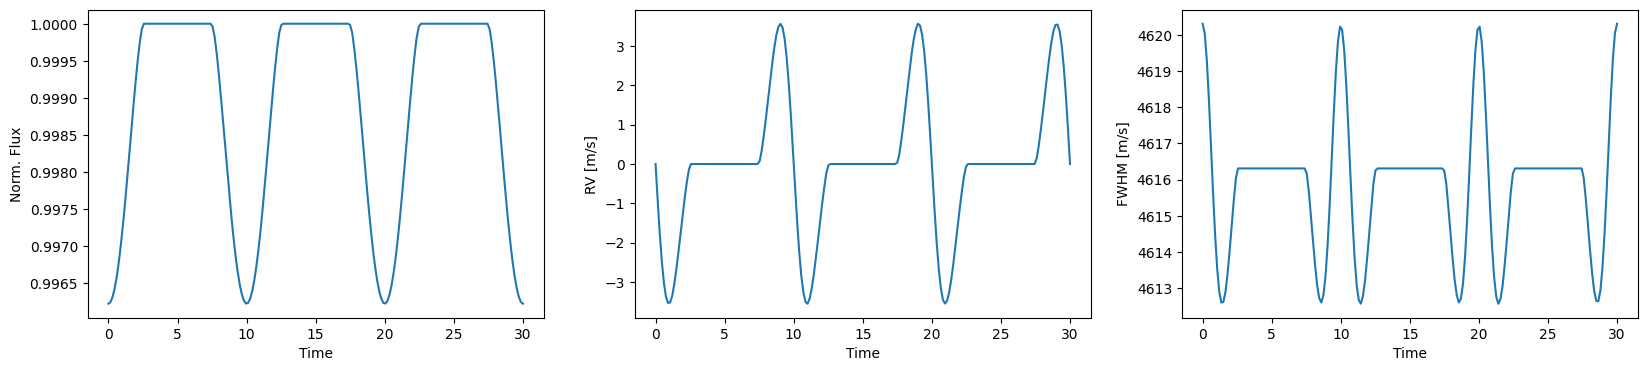

In [6]:
fig, ax = plt.subplots(1,3,figsize=(20,4))
ax[0].plot(t_sampling,ss.results['lc'])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Norm. Flux')
ax[1].plot(t_sampling,ss.results['rv'])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('RV [m/s]')
ax[2].plot(t_sampling,ss.results['fwhm'])
ax[2].set_xlabel('Time')
ax[2].set_ylabel('FWHM [m/s]')
plt.show()

The plots can be automatically generated using the method `ss.plot_forward_results()`. The plot will be saved under the _starsim/plots_ folder. Lets show it with a little trick:

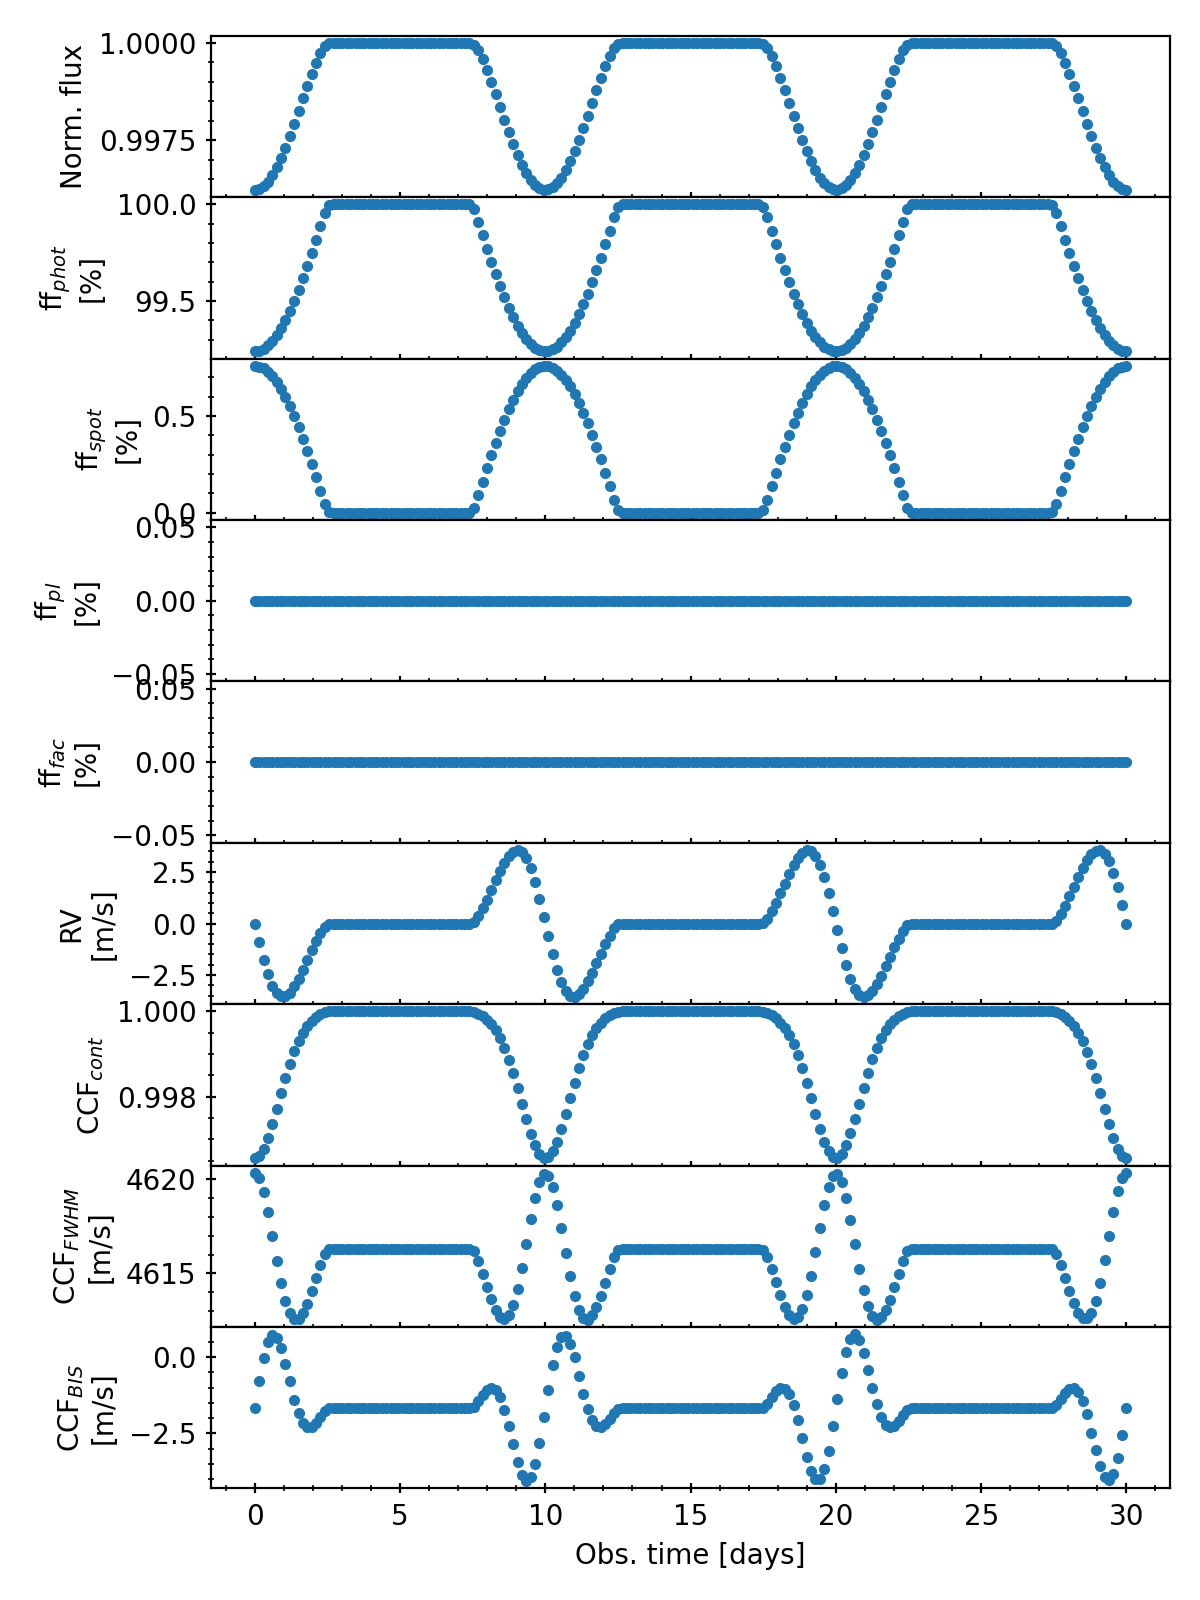

In [7]:
ss.plot_forward_results()
from IPython.display import Image  #trick to show a saved image
Image(filename='starsim/plots/forward_results.png',width=400) 

As you can se the figure contains subplots of more observable than the ones selected, such as the filling factors or all the CCF parameters. 

Note that even though we have set the rotation period to 2.5 with `ss.rotation_period=2.5`, the simulations show that the rotation period is still 10. Bear in mind that every time you define the ss object, it will read the starsim.conf file again and ignore all the changes made before, such as setting the period to 2.5.

### 5.1.- Introducing the chromatic indexs indicators

Starsim can also be tuned to work as an echelle spectrograph, computing the CCF parameters for each of the echelle orders containing a different wavelength range. This can be useful to simulate the dependence of the different parameters with the wavelength, which are called the chromatic indicators. To use this mode, one needs to generate a text file containing the number of order, the initial wavelength, and the final wavelength of a certain spectrograph, and store it in the folder _starsim/orders_CRX_. Lets run again the previous spot map adding the cromatic index and lot the results. Be aware that this mode will be much slower than with the 'lc' or 'rv' observables, since it has to repeat the simulation for each order (it should take ~1 minute). To simulate all the observables, you only need to set `observables=['lc','rv','crx']` as shown below:

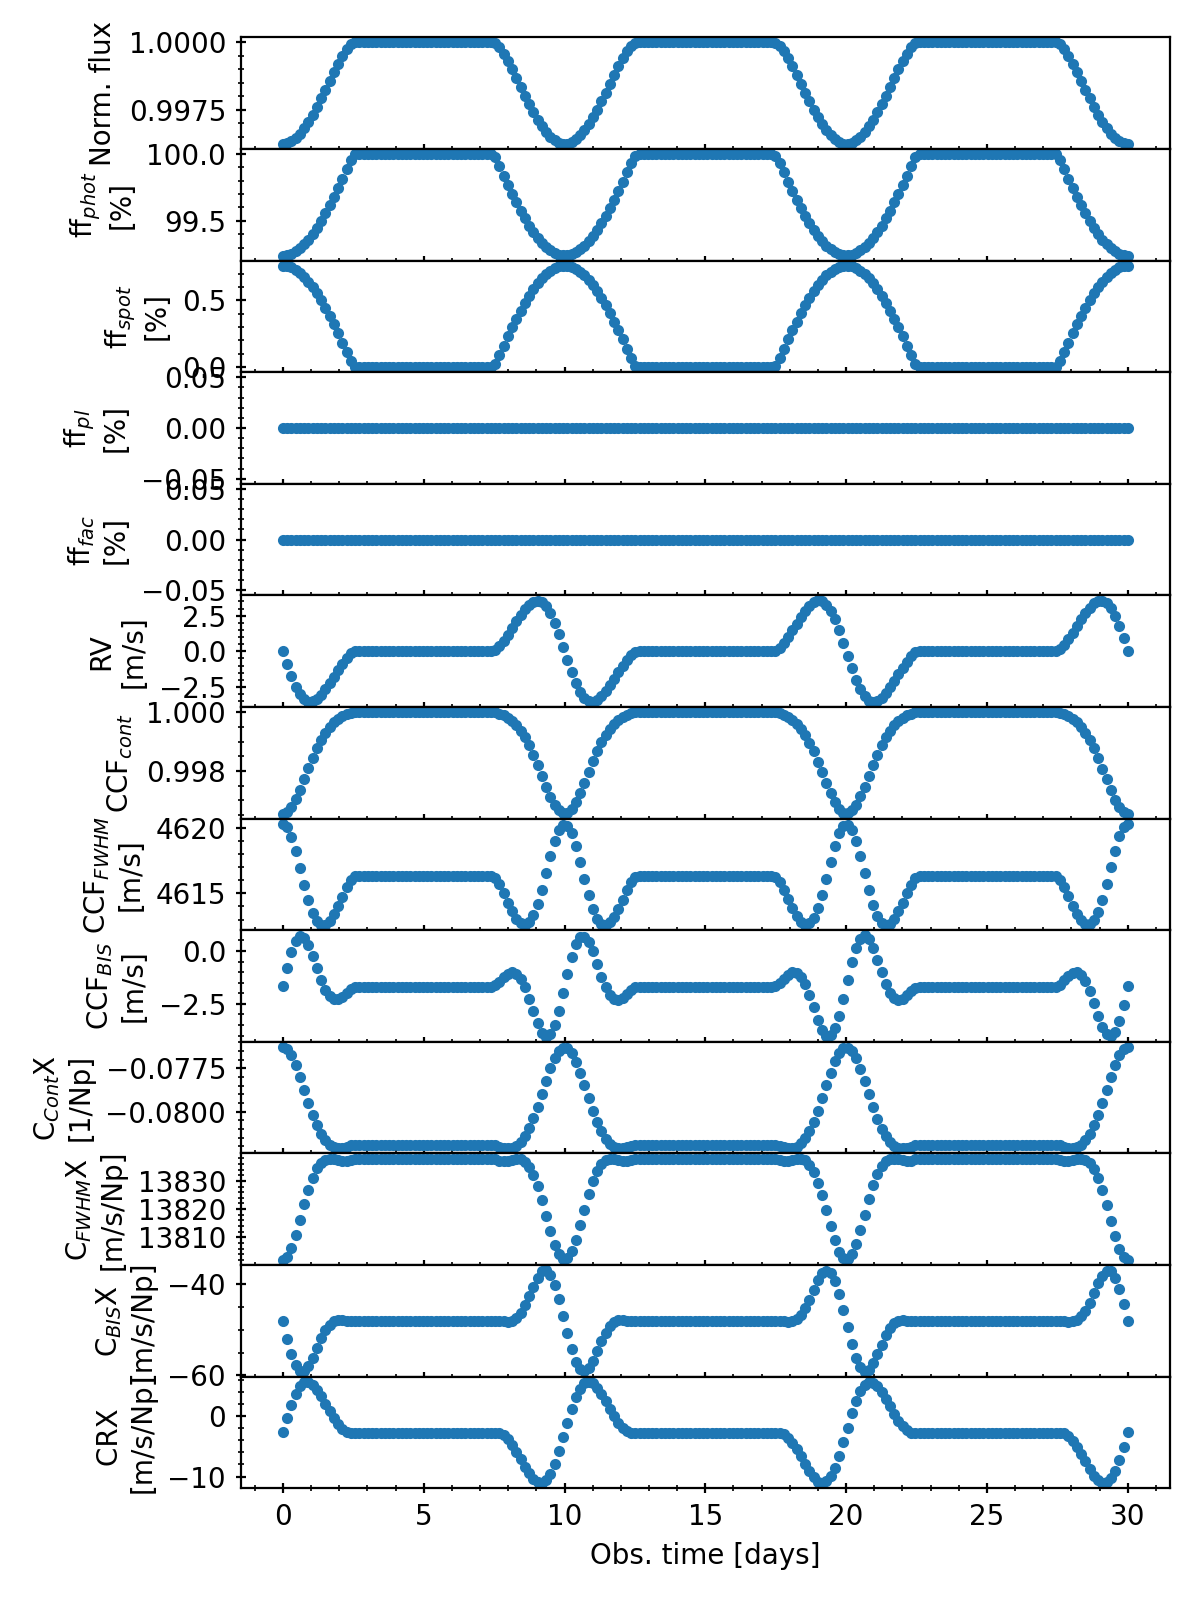

In [8]:
ss.compute_forward(observables=['lc','rv','crx'],t=t_sampling)
ss.plot_forward_results()
from IPython.display import Image  #trick to show a saved image
Image(filename='starsim/plots/forward_results.png',width=400) 

### 5.2.- Adding a planet

starsim can also simulate the effect of a transiting planet over the photometry, and all spectroscopic observables, including the rossiter-mclaughin effect and spot-crossing effects. To include a planet in the simulation, simply set _simulate_planet_ to 1 in starsim.conf, and run the forward model as before. We will reduce the simulated time to highlight the transit.

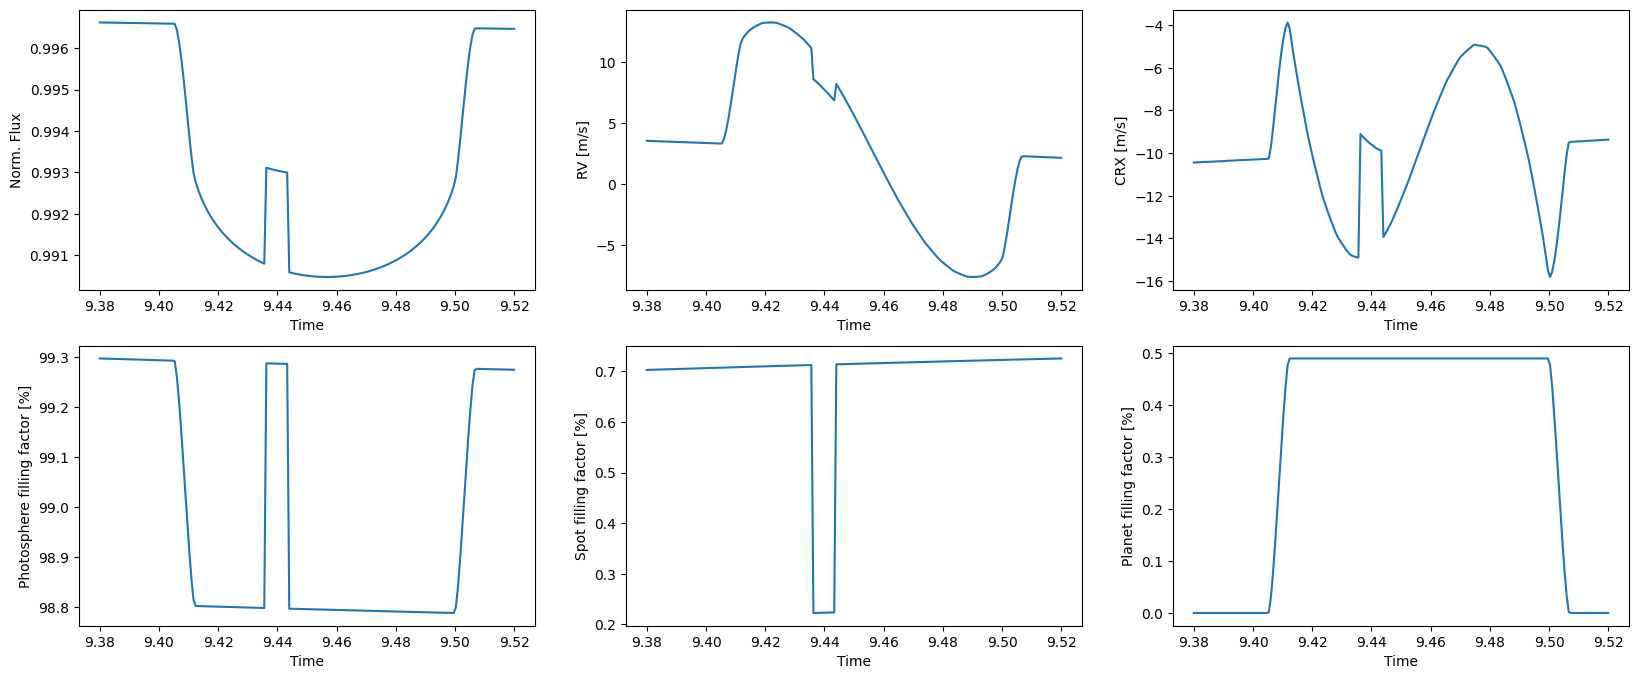

In [9]:
ss.simulate_planet=int(1) #Important to set it as an integer
t_sampling=np.linspace(9.38,9.52,200) #define the sampling time
ss.compute_forward(observables=['lc','rv','crx'],t=t_sampling) #simulate all observables

fig, ax = plt.subplots(2,3,figsize=(20,8))
ax[0,0].plot(t_sampling,ss.results['lc'])
ax[0,0].set_xlabel('Time')
ax[0,0].set_ylabel('Norm. Flux')
ax[0,1].plot(t_sampling,ss.results['rv'])
ax[0,1].set_xlabel('Time')
ax[0,1].set_ylabel('RV [m/s]')
ax[0,2].plot(t_sampling,ss.results['crx'])
ax[0,2].set_xlabel('Time')
ax[0,2].set_ylabel('CRX [m/s]')
ax[1,0].plot(t_sampling,ss.results['ff_ph'])
ax[1,0].set_xlabel('Time')
ax[1,0].set_ylabel('Photosphere filling factor [%]')
ax[1,1].plot(t_sampling,ss.results['ff_sp'])
ax[1,1].set_xlabel('Time')
ax[1,1].set_ylabel('Spot filling factor [%]')
ax[1,2].plot(t_sampling,ss.results['ff_pl'])
ax[1,2].set_xlabel('Time')
ax[1,2].set_ylabel('Planet filling factor [%]')
plt.show()

As you can see in the plots, the transit stars at t=9.4, and there is a spot crossing event at t=9.44. This is reflected also in the filling factors.

Starsim not only simulates the drop in flux and the rossiter-Mclaughin effect, but also reproduces the effect over all other observables, such as the CRX. 

The spot crossing event produces a very sharp change in the observables, due to the lack of resolution in the overlapping between spot and planet. To avoid this, one should use the `precise` mode in starsim.cong with a very dense grid, but would be very time consuming to reproduce it here.

## 6.- Inverse mode

In the inverse model, the user provides any number of time-series of different observables, and starsim optimizes the spot map and/or the stellar parameters to match the observations. There are three main modes:

1. Compute N inversions with a given set of stellar parameters to obtain N spot maps. This is done with the method `best_maps, lnLs = ss.compute_inverseSA(N_inversions=N)` and returns the N best maps and log-likelihoods. Also returns the file `inversion_stats.npy` with the best maps and log-likelihoods. Uses the fast mode, so is not recommended for spots larger than ~20 deg.

2. Optimize the stellar parameters. Inside a user-defined range, starsim selects random stellar parameters, and for each set, computes the best spot map and the best likelihood. This method can be called with `ss.optimize_inversion_SA()` and as an output produces the file `inversion_MCMCSA_stats.npy` with the log-likehood, the stellar parameters and spot map of each step. Also recommended for spots larger than ~20deg.

3. Optimize stellar parameters and spot map simultaneously using an MCMC. This method treats the spot parameters as additional stellar parameters, and can be used in both fast and precise modes, so is recommended for stars with big spots or for cases with no more than 2-3 spots. It is executed with `ss.optimize_MCMC()`. The output consists of a plot with the MCMC chains, a corner plot with the results and a list with the optimized parameters and uncertainties. 

### 6.1.- Loading the time series

First of all let's create som dummy observables which we will invert. In this example we are going to use one RV curve and one light curve. To make it simpler, manually modify the `spotmap.dat` file to be:

0.0 40.0 90.0 30.0 5.0 0.0 0.0  0 0 1 1 1 0 0 

0.0 40.0 60.0 310.0 2.0 0.0 0.0  0 0 1 1 1 0 0

That is, two spots spot born at t=0, with a lifetime of 40 days, at colatitudes of 90 and 60 deg, longitudes of 30 and 310 deg, and radii of 5 and 2 deg. The integers in the last 7 columns are used to fix (0) or optimize (1) the parameters of the first 7 columns. That is, here we will optimize the colatitude, longitude and spot size of both spots.

In [10]:
ss=starsim.StarSim(conf_file_path='starsim.conf') #initialize configuration and spot map
t_sampling=np.linspace(0,30,30) #sampling times
ss.compute_forward(observables=['lc','rv'],t=t_sampling) 

y_lc=ss.results['lc']
dy_lc=0.0001*np.ones(len(y_lc)) #Dummy errors
y_rv=ss.results['rv']
dy_rv=0.01*np.ones(len(y_rv)) #Dummy errors

Lets now load the data into starsim. It is done with the method `ss.load_data`, and it can read data from either a three-column text file using the argument filename, or from already defined python variables, as in this case.

In [11]:
ss.load_data(t=t_sampling,y=y_lc,yerr=dy_lc,instrument='DUMMY-lc',observable='lc',filter_name='TJO_R.dat',wvmin=5500,wvmax=9500,offset=1,jitter=0,fix_offset=True,fix_jitter=False)
ss.load_data(t=t_sampling,y=y_rv,yerr=dy_rv,instrument='DUMMY-rv',observable='rv',wvmin=5500,wvmax=9500,offset=0,jitter=0,fix_offset=True,fix_jitter=False)


Make sure that you specify the correct wavelength range and filter that the instrument is using. In this case we are using the same values as the specified in starsim.conf to run the forward model before, but may be different in your case.
Also, additional options to fit the data is given. If desired, you can add to the data a jitter term and an offset (multiplicative for the lc, fwhm and contrast observables, additive fr the others). Also, you can fix these parameters or let starsim optimize them at each inversion. In this case we are going to fix the offset.

The loaded data can be accesed with `ss.data['INSTRUMENT_NAME']['OBSERVABLE_NAME']`

### 6.2.- Inversion

Let's now invert this data and obtain 4 spot_maps. This can be parallelized, so make sure to use a convinient number of CPUs in the N_cpus option in starsim.conf or through ss.N_cpus. Remember that according to the spotmap file, we are optimizing the colatitude, longitude and size of a single spot. 

The execution of this line of code may take several minutes, but in your terminal it should show a progress bar and detailed information of the status of each inversion, with info about the step number, the acceptance fraction and the current best log-likelihood. In starsim.conf there is an option `N_iters_SA` to control the number of steps in each inversion. The default value is 7000, but can be increased to obtain better results or decreased to obtain faster results.

In [12]:
best_maps, lnLs = ss.compute_inverseSA(N_inversions=4)

Computing 4 inversions of 2 spots each.

Using data from the instruments:
- DUMMY-lc , with the observables:
	- lc
- DUMMY-rv , with the observables:
	- rv


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1622.71it/s]


 Step=6633/7000; Acc_frac=0.0252; lnL=260.684Inversion 2 complete with a lnL of 330.9864411265765
 Step=6999/7000; Acc_frac=0.0444; lnL=311.360Inversion 0 complete with a lnL of 311.3604529303613
 Step=6756/7000; Acc_frac=0.0247; lnL=260.684Inversion 3 complete with a lnL of 340.47230610846356
 Step=6999/7000; Acc_frac=0.0239; lnL=260.684Inversion 1 complete with a lnL of 260.68360543097504


The idea of repeating the inversion N times is to increase statistics, since in some cases the optimization may be trapped in a local maxima.
Once the inversion is finished, one can plot the resulting inverted time series with the funcion `ss.plot_inversion_results(best_maps,lnLs,Npoints=500)`, which plot the loaded data togther with the time series obtained by each inversion. The plots of the best spot maps at the desired time stamps are obtained with
`ss.plot_spot_map(best_maps,tref=[t1,t2,t3,...])`. The map of the active regions at each longitude and time is obtained with
`ss.plot_active_longitudes(best_maps,tini=t_sampling[0],tfin=t_sampling[-1],N_obs=200)`.

In [13]:
ss.plot_inversion_results(best_maps,lnLs,Npoints=500)
ss.plot_spot_map(best_maps,tref=[10,11])
ss.plot_active_longitudes(best_maps,tini=t_sampling[0],tfin=t_sampling[-1],N_obs=200)

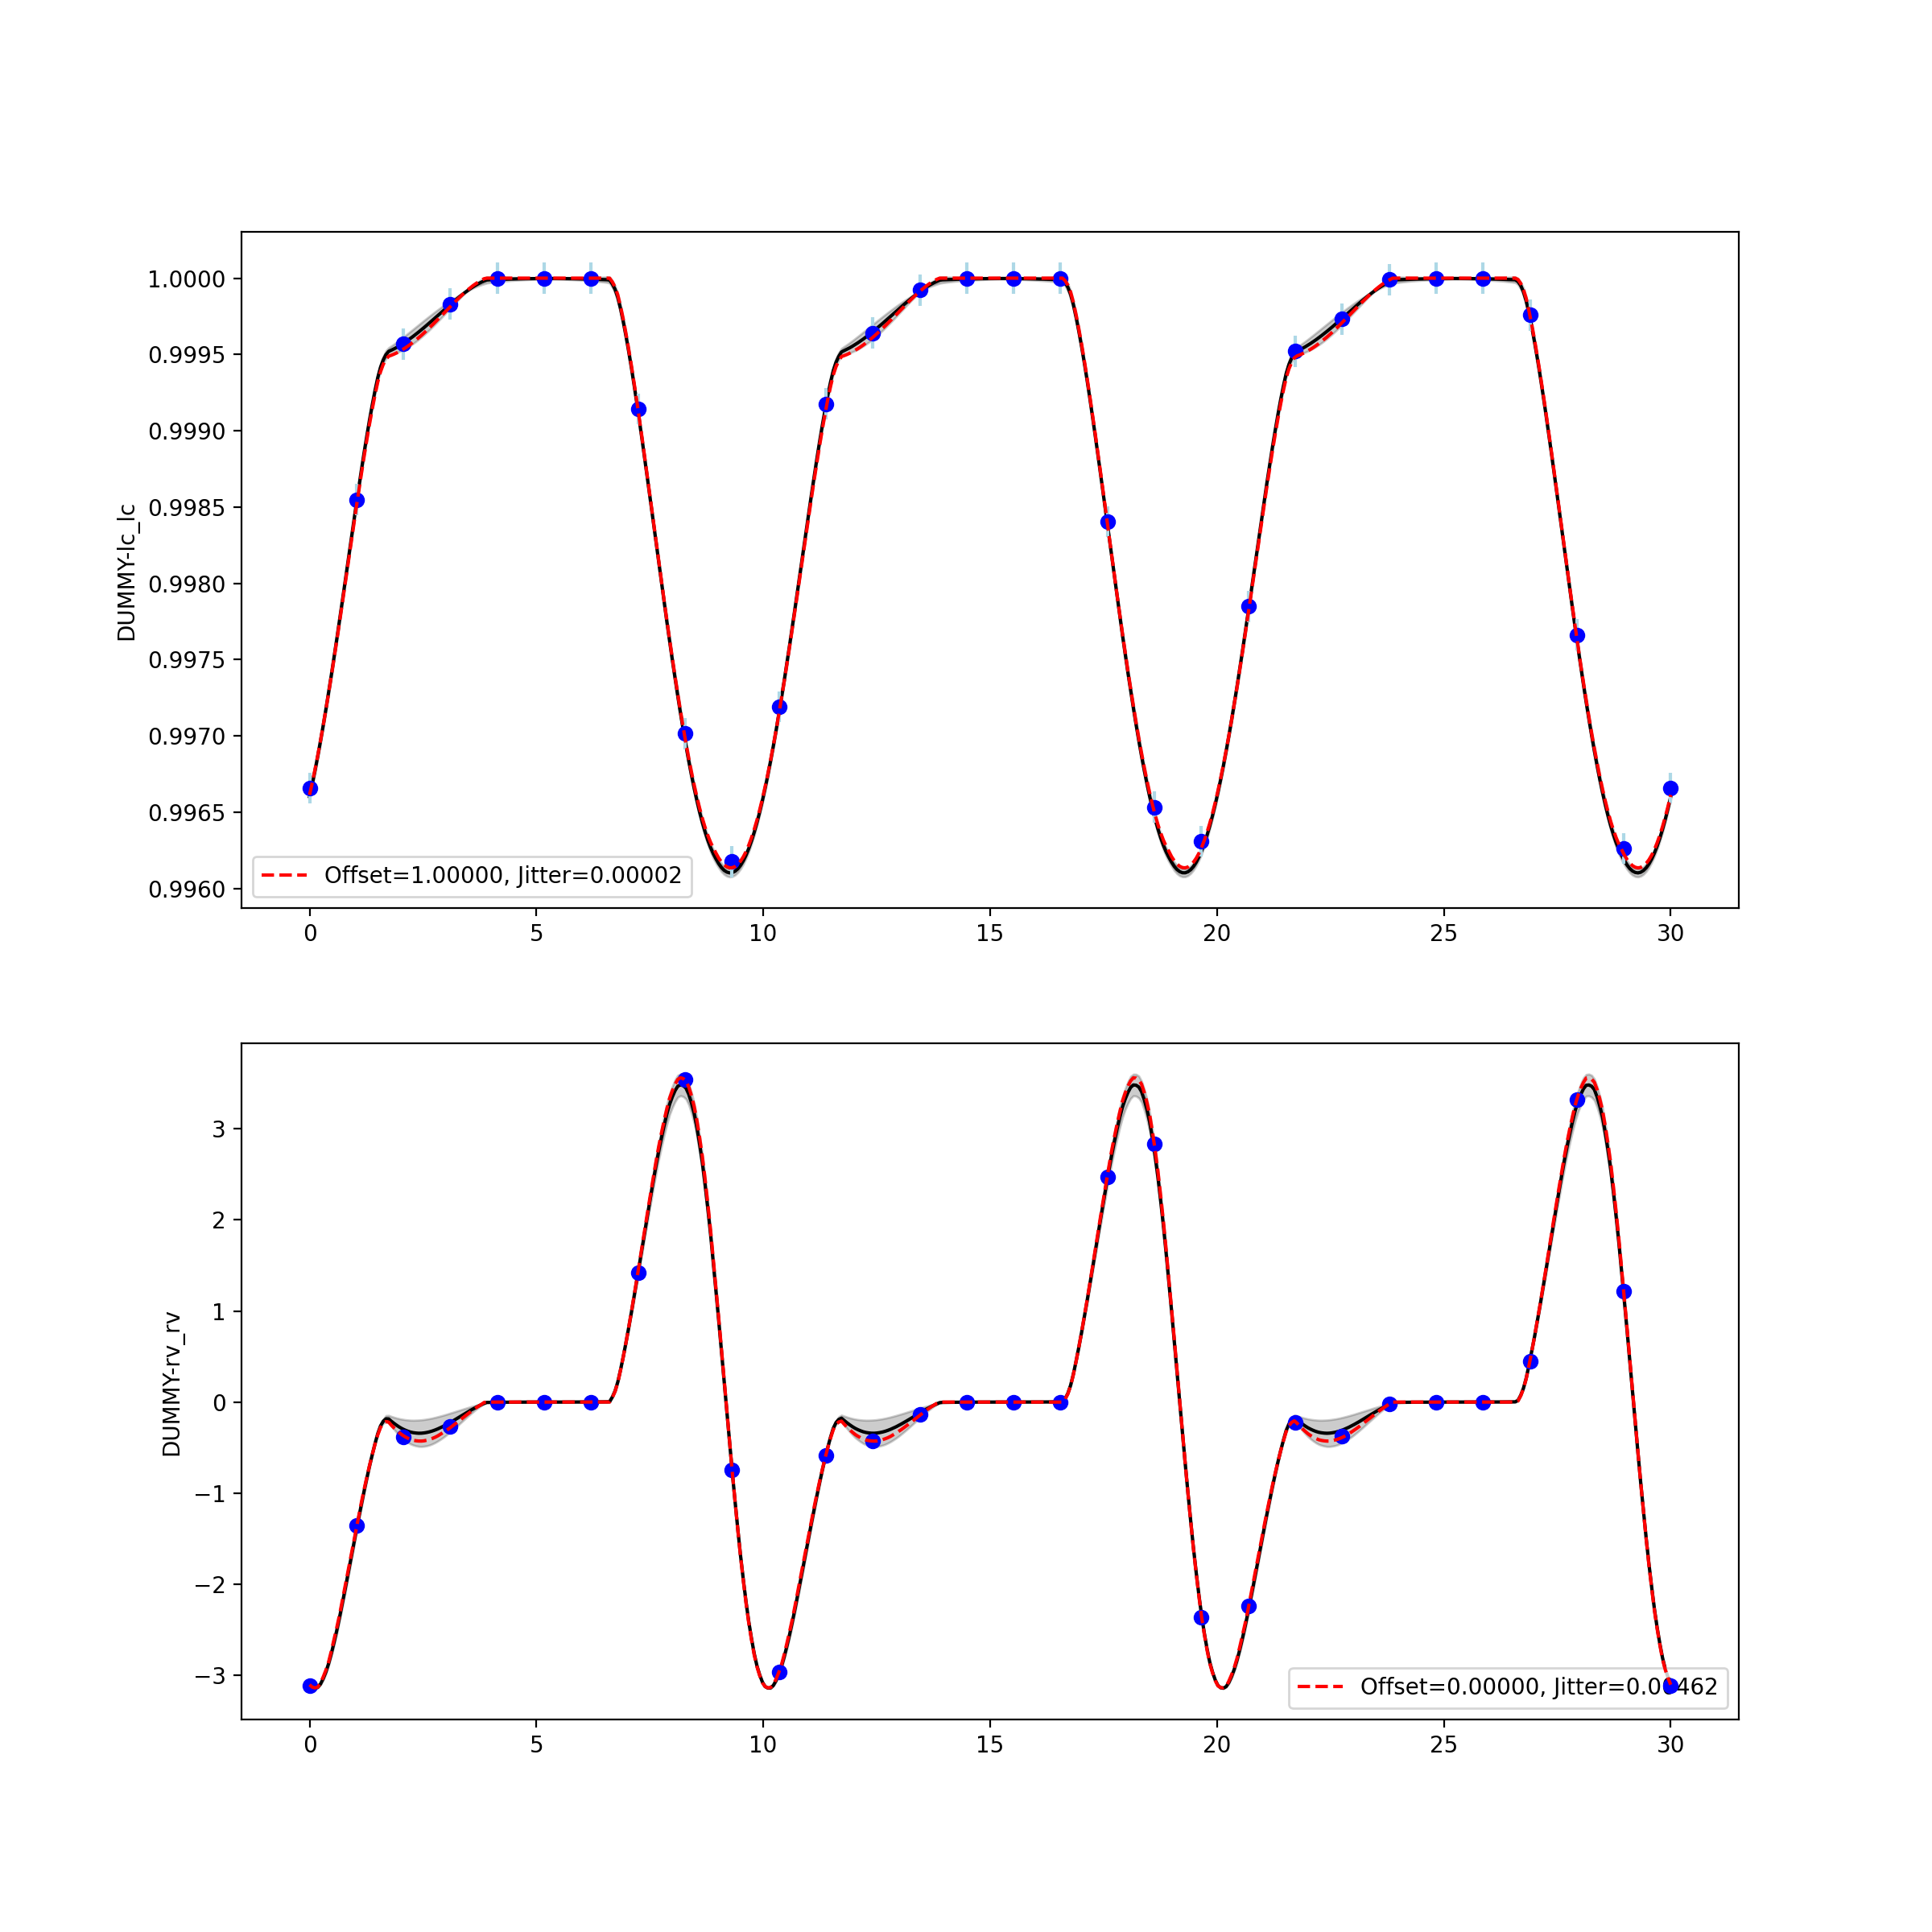

In [14]:
Image(filename='starsim/plots/inversion_timeseries_result.png',width=600) 

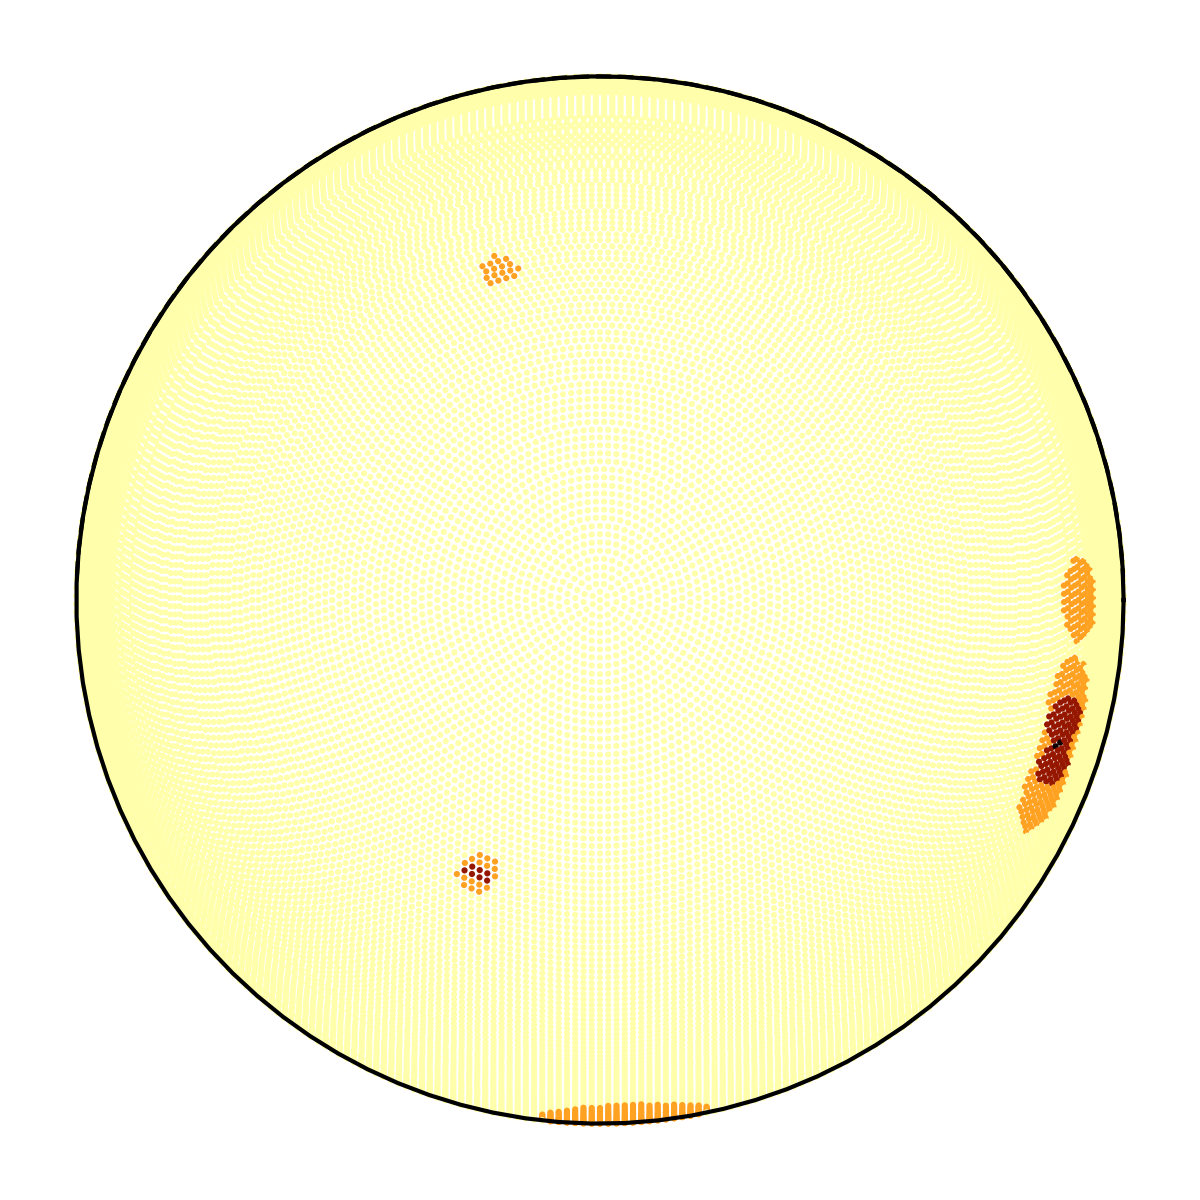

In [15]:
Image(filename='starsim/plots/inversion_spotmap_t_11.0000.png',width=400) 

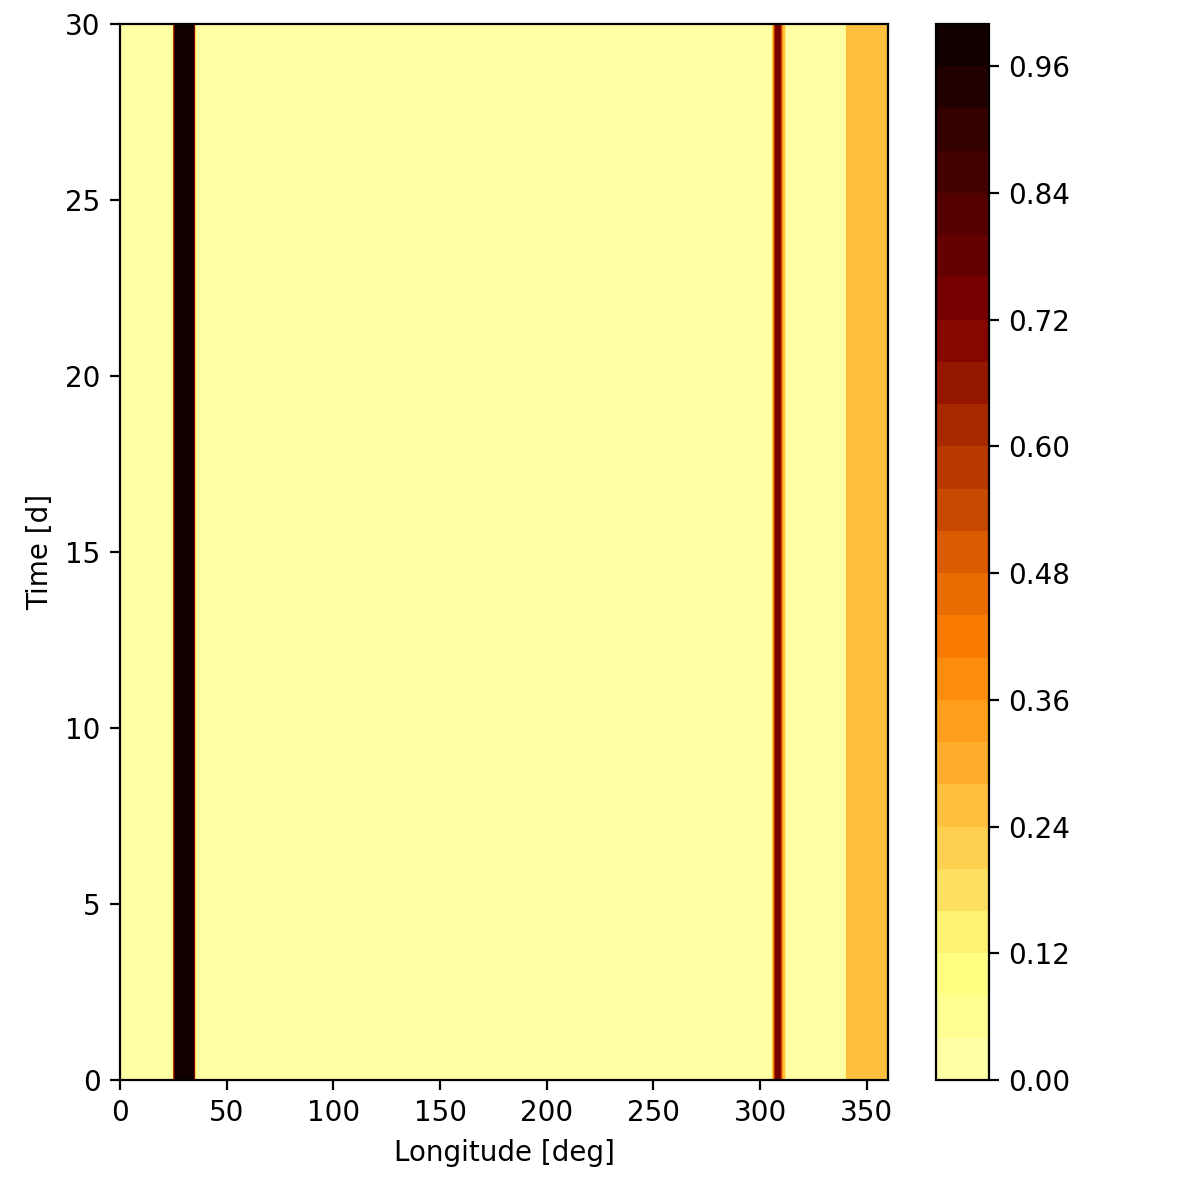

In [16]:
Image(filename='starsim/plots/active_map.png',width=400) 

### 6.3.- Stellar parameter optimization
The stellar parameters of the star can also be optimized by randomly exploring a grid of values and performing an inversion for each of those. This is an expensive routine, that may take several hours depending on the number of iterations you may want. We start by selecting in the configuration file `starsim.conf` the parameters that we want to optimize. Lets optimize the contrast temperature only. You should have something like this at line 88.

#stellar properties  
prior_t_eff_ph :              [0 , 3000 , 6000 , 0 , 4700 , 5500]    # Teff of the star photosphere (K)  
prior_spot_T_contrast :       [1 , 0 , 1000.0 , 0 , 0,500]    # Spot temperature contrast (K)  
prior_facula_T_contrast :     [0 , 0 , 100 , 0 , 0 , 100]    # Facula temperature contrast (K)  
prior_q_ratio :               [0 , 0 , 3 , 0 , 0 , 3]    # Facular to spotted area ratio Q  
prior_convective_blueshift:   [0 , -1 , 1.5 , 0 , -1 , 1.5]    # Convective shift factor.   
prior_p_rot :                 [1 , 9 , 11 , 0 , 9, 11]    # Rotation period (days)  
prior_inclination  :          [0 , 40 , 90, 0 , 40 , 90]    # Inclination of rotation axis (deg, 0 is pole on rotation)  
prior_stellar_radius :        [0 , 0.5, 1.5 , 0 , 0.5 , 1.5]    # Stellar radius (Rsun)  
prior_limb_darkening_q1 :     [0 , 0, 1, 0, 0.3, 0.5] #Limb darkening coefficient q1  
prior_limb_darkening_q2 :     [0 , 0, 1, 0, 0.05, 0.2] #Limb darkening coefficient q2 (don't fit if LD_law is linear)  
#planet  
prior_period_planet:           [0 , 1 , 15 , 0 , 2.77 , 2.78] #period of the planet (days)  
prior_time_transit_planet:	   [0 , 2457400.3 , 2457400.5 , 0 , 2457400 ,2457402.7]  #time of central transit (day)  
prior_semi_amplitude_planet:   [0 , 0 , 2000 , 0 , 120 , 130]  #RV semi-amplitude of panet (m/s)  
prior_esinw_planet:            [0 , -0.7 , 0.7 , 0 , -0.1 , 0.1] #eccentricity times sine of arg. periastron  
prior_ecosw_planet:            [0 , -0.7 , 0.7 , 0 , -0.1 , 0.1]  #eccentricity times cosine of arg. periastron  
prior_radius_planet:           [0 , 0.05 , 0.1 , 0 , 0 , 0.5] #Radius of planet (R*)  
prior_impact_parameter_planet: [0 , 0 , 1 , 0 , 0 , 1] #Impact parameter of the planet. b>1+Rp means no transit.  
prior_spin_orbit_planet:       [0 , 0 , 15 , 0 , 0 , 360]  # Spin-orbit angle of the transit chord (deg)  

Each line corresponds to a different stellar parameter. In brackets, there are 6 numbers: The first one is to optimize it (1) or leave it fixed (0). The second and third are the lower an upper limits where the optimization will be performed. **Make sure that the fixed parameters are within the specified limits, it will not throw an error but infinite log-likelihoods**. The third, fourth and fifth columns are the priors to generate the initial values. In this case we only optimize the spot contrast temperature, with an uniform prior between 0 and 500, and limits between 0 and 1000 (note that since we use an uniform prior there will be no values over 500, the limit is used with none uniform priors).

The last step is to select the number of random evaluations that we starsim will make. This is set with the parameter N_steps in `starsim.conf`. We set a small value of 8 only to sped up the process, but we recommend values larger than 1000 at least.

Before starting the optimization we should restart the ss object to apply the changes in starsim.conf.

In [17]:
ss=starsim.StarSim(conf_file_path='starsim.conf') #initialize configuration and spot map
ss.load_data(t=t_sampling,y=y_lc,yerr=dy_lc,instrument='DUMMY-lc',observable='lc',filter_name='TJO_R.dat',wvmin=5500,wvmax=9500,offset=1,jitter=0,fix_offset=True,fix_jitter=False)
ss.load_data(t=t_sampling,y=y_rv,yerr=dy_rv,instrument='DUMMY-rv',observable='rv',wvmin=5500,wvmax=9500,offset=0,jitter=0,fix_offset=True,fix_jitter=False)


And the optimization is started with (it may take a few minutes to finish):

In [18]:
ss.optimize_inversion_SA()


Using data from the instruments:
- DUMMY-lc , with the observables:
	- lc
- DUMMY-rv , with the observables:
	- rv
Searching random grid for best stellar parameters. Optimizing spotmap at each step.
Total parameters to optimize: 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 3103.73it/s]


[347.577   9.088] 115.12
[11.826  9.231] 120.68
[320.73    9.034] 112.42
[403.005  10.776] 131.01
[482.402  10.7  ] 136.49
[328.027   9.043] 113.51
[272.501  10.939] 124.55
[461.898  10.821] 129.50


Let's now print the results and plot some figures. It only takes solutions within DeltalnL of the best reusult. We recommend ussing DeltalnL<=15, since are comparable fits, but in this tutorial we use 100 since the number of realizations is really small.

In [19]:
ss.plot_optimize_inversion_SA_results(DeltalnL=100)

Results of the inversion process:
	 -Mean and 1 sigma confidence interval:
	 	 T$_{{eff}}$  =  3500.0 (fixed) 
	 	 $\Delta$ T$_{{sp}}$ = 337.80199+117.58566-59.96929
	 	 $\Delta$ T$_{{fc}}$  =  30.0 (fixed) 
	 	 Fac-spot ratio  =  0.0 (fixed) 
	 	 CS  =  0.0 (fixed) 
	 	 P$_{{rot}}$ = 9.96550+0.85053-0.91715
	 	 inc  =  90.0 (fixed) 
	 	 R$_*$  =  0.5 (fixed) 
	 	 q$_1$  =  0.43 (fixed) 
	 	 q$_2$  =  0.122 (fixed) 
	 	 P$_{{pl}}$  =  0.932 (fixed) 
	 	 T$_{{0,pl}}$  =  2.0 (fixed) 
	 	 K$_{{pl}}$  =  1.0 (fixed) 
	 	 esinw  =  0.0 (fixed) 
	 	 ecosw  =  0.0 (fixed) 
	 	 R$_{{pl}}$  =  0.07 (fixed) 
	 	 b  =  0.0 (fixed) 
	 	 $\lambda$  =  0.0 (fixed) 
	 -Mean and standard deviation:
	 	 $\Delta$ T$_{{sp}}$ = 337.80199+-137.32941
	 	 P$_{{rot}}$ = 9.96550+-0.85907
	 -Best solution, with maximum log-likelihood of 136.4901814373034
	 	 $\Delta$ T$_{{sp}}$ = 482.40232
	 	 P$_{{rot}}$ = 10.70013


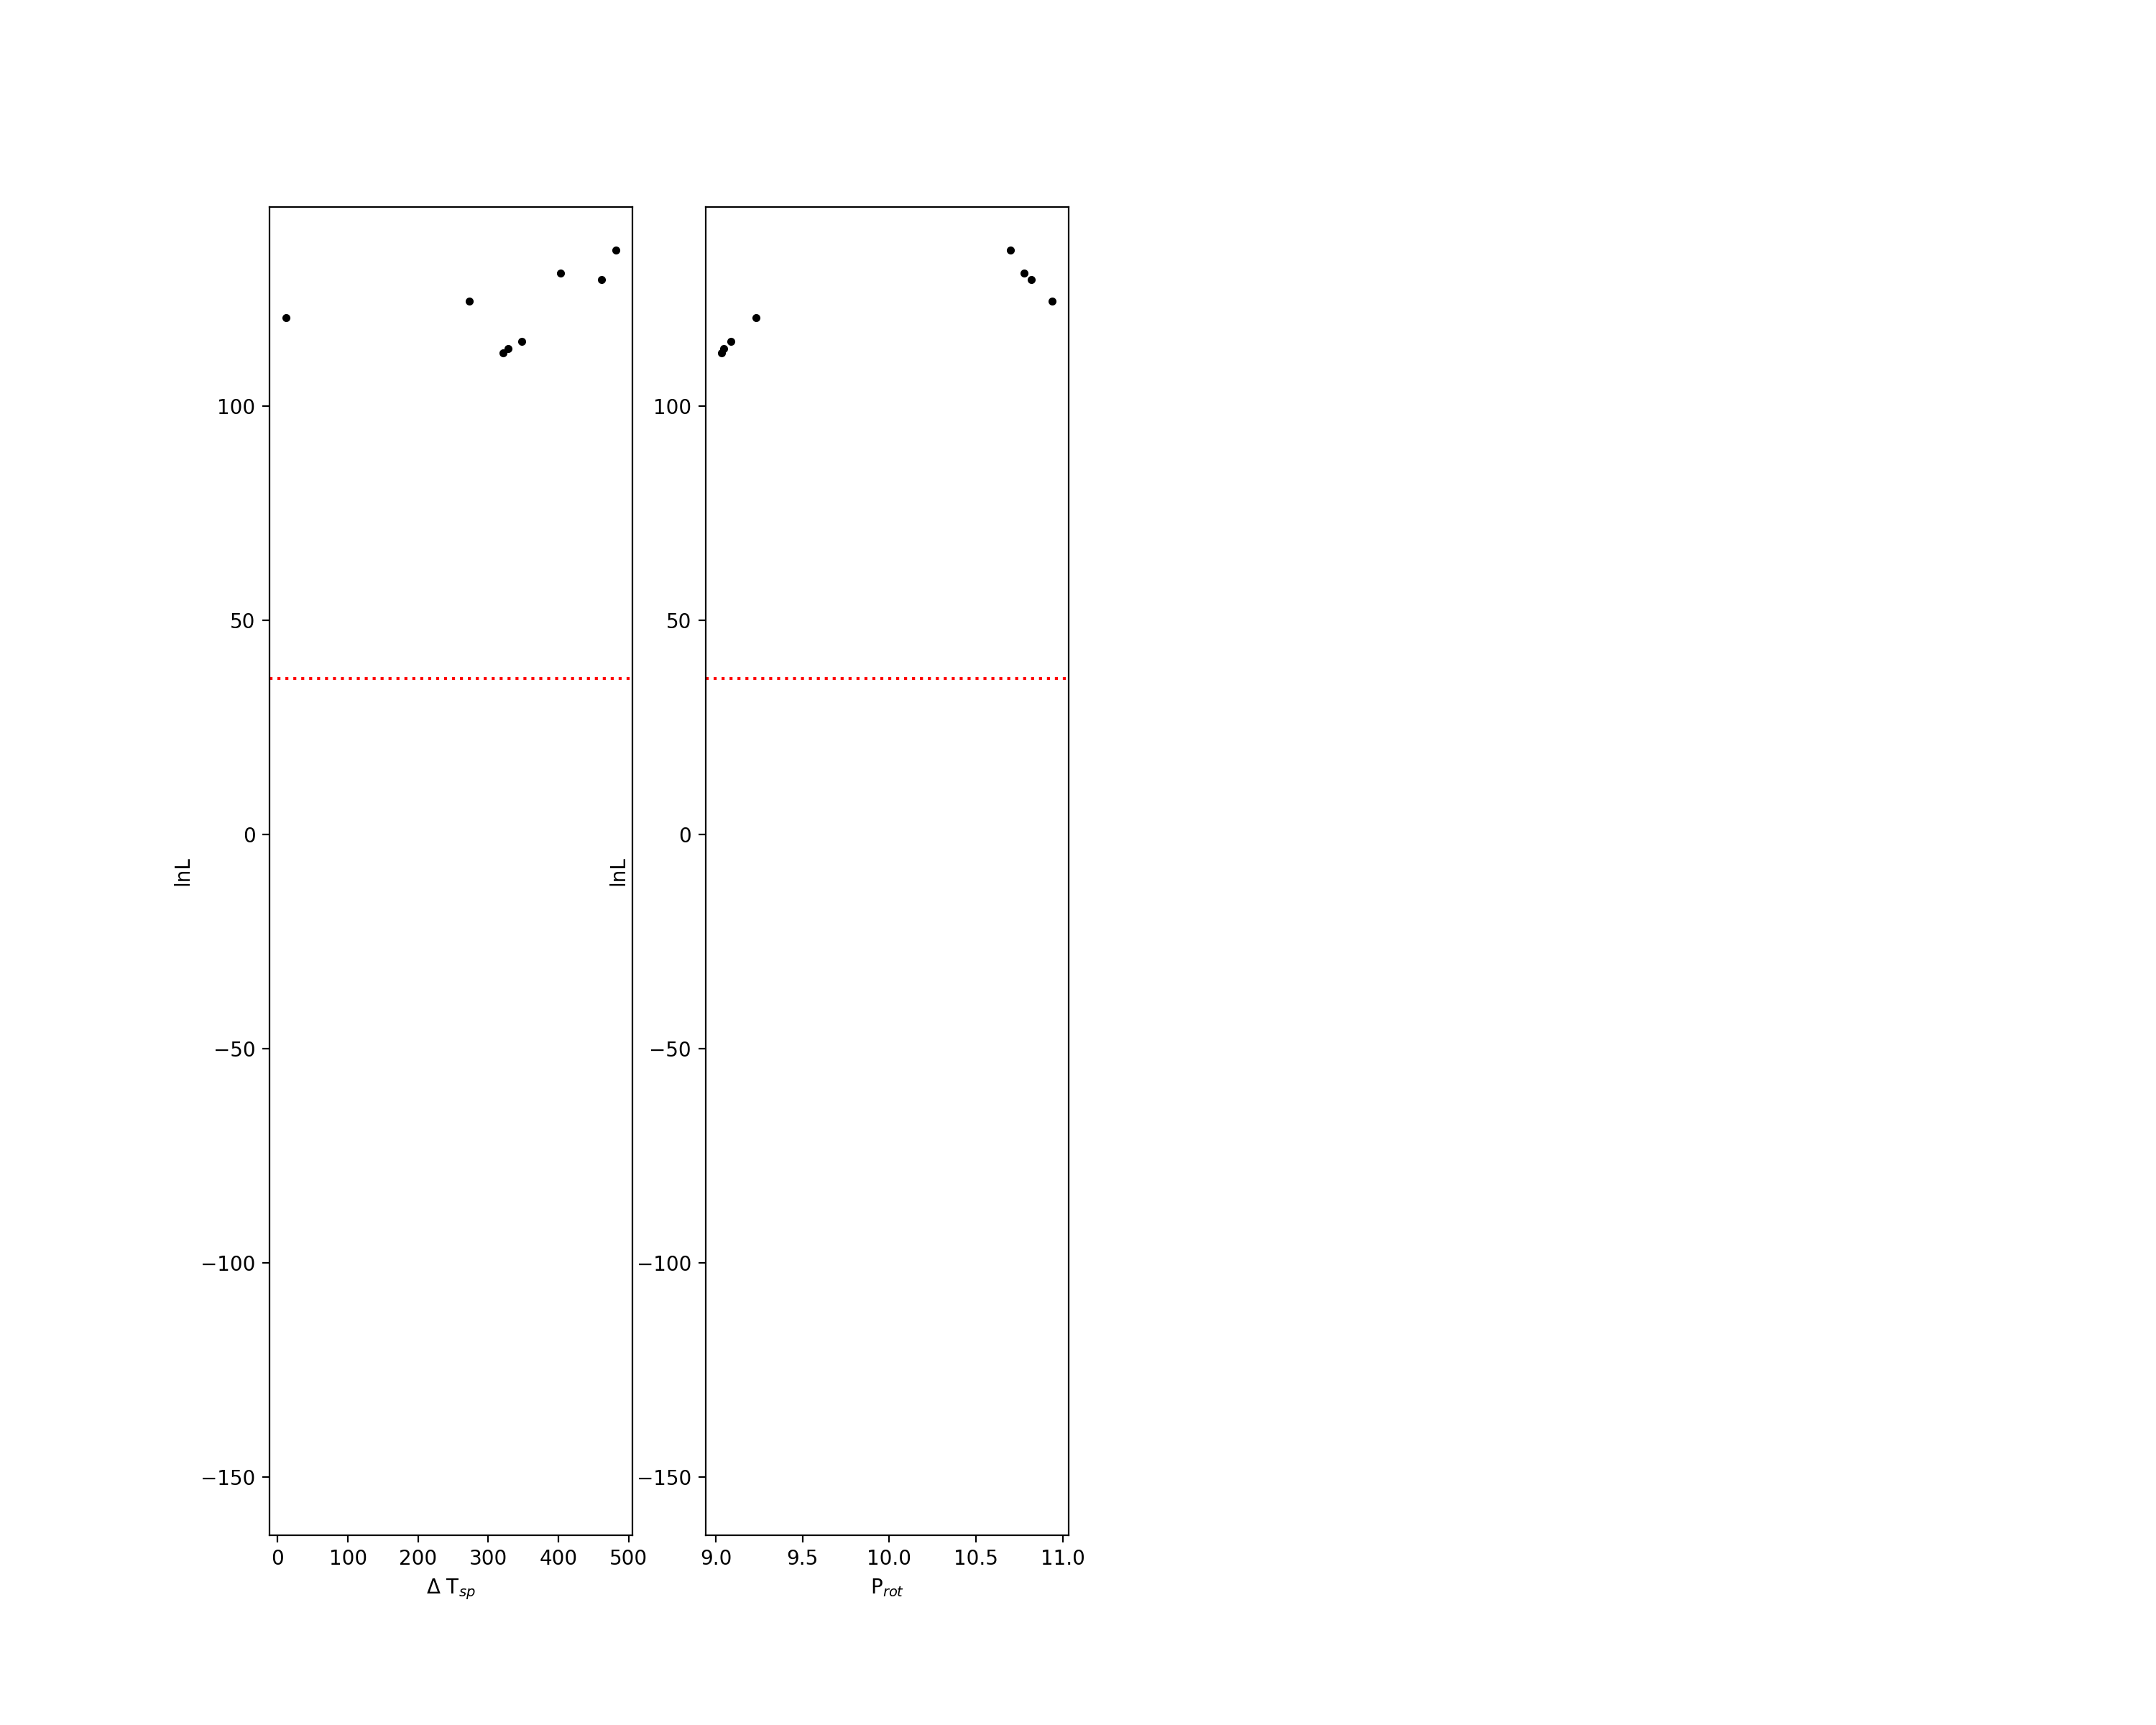

In [20]:
Image(filename='starsim/plots/inversion_MCMCSA_likelihoods.png',width=800) 

This plot the log-likelihoods of each evaluation. As you can see, rotation periods near 10 have the highest likelihoods. However, to obtain significant statistics we should perform much more iterations. The points above the red line are those within DeltalogL, which are selected for the next plots.

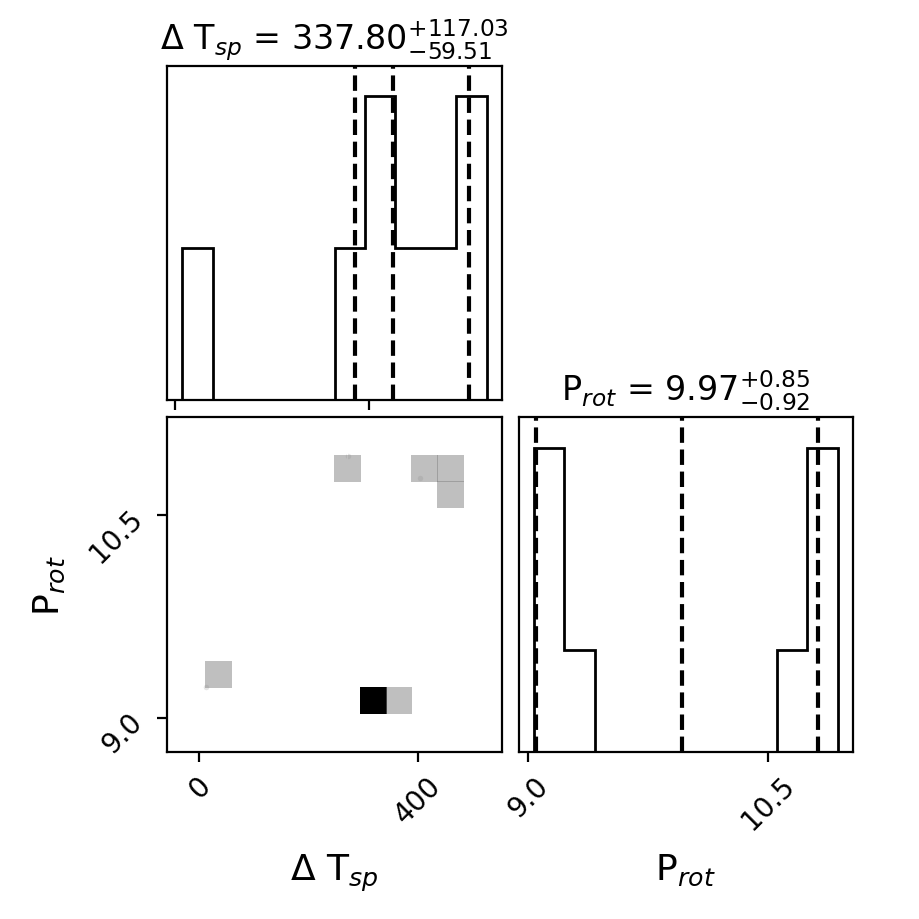

In [21]:
Image(filename='starsim/plots/inversion_MCMCSA_cornerplot.png',width=400) 

With more iterations, the histogram would aproach the input values. Finally, we plot the models of the solutions within DeltalnL.


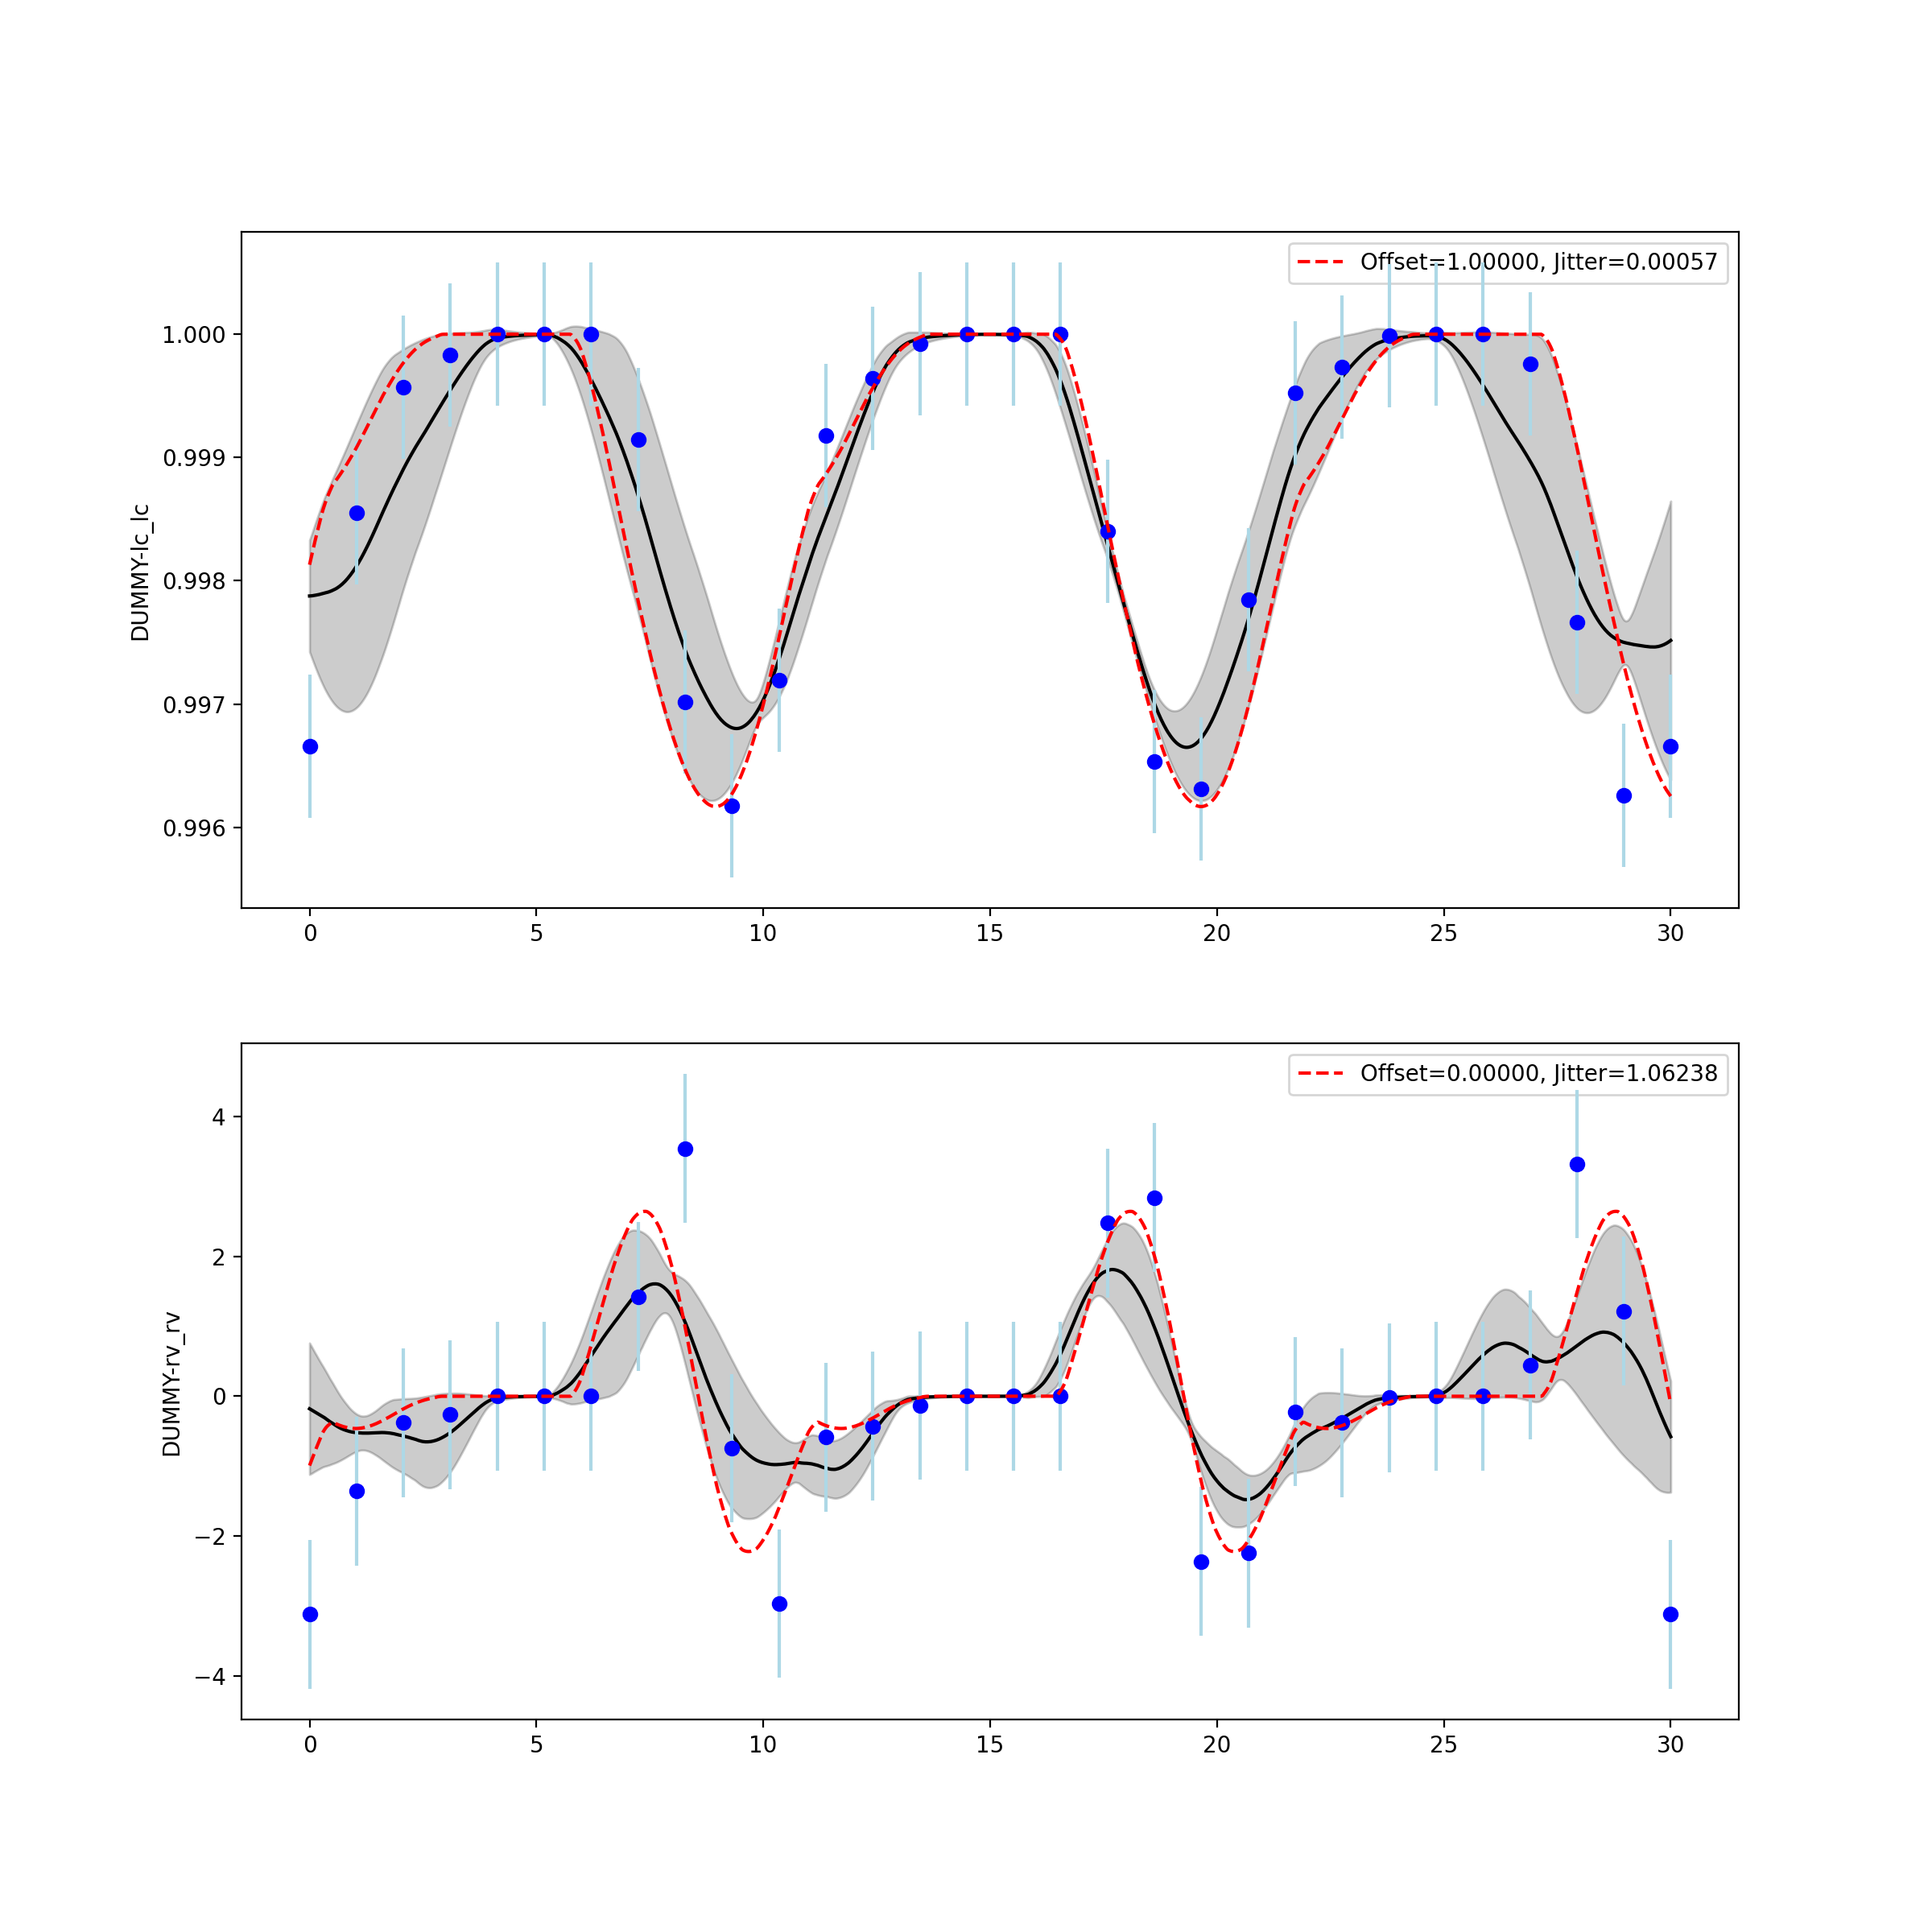

In [22]:
Image(filename='starsim/plots/inversion_timeseries_result.png',width=500) 

If you want to play with the results, they are saved in the file `inversion_MCMCSA_stats.npy`. To acces them simply do:

In [23]:
lnLs, params, best_map = np.load('starsim/results/inversion_MCMCSA_stats.npy',allow_pickle=True)

print('This is the best lnL:',np.max(lnLs))
print('These are the parameters of the best solution',params[np.argmax(lnLs)])
print('This is the best map of the best solution',best_map[np.argmax(lnLs)])

This is the best lnL: -490.7085948212218
These are the parameters of the best solution [5.10000000e+03 1.28619032e+03 3.00000000e+01 0.00000000e+00
 1.45075298e+00 1.15163295e+01 7.04811025e+01 1.04229573e+00
 3.80000000e-01 3.30000000e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
This is the best map of the best solution [[2.45881925e+06 9.99295489e+01 1.74240091e+02 1.90985544e+02
  9.87178530e+00 0.00000000e+00 0.00000000e+00]
 [2.45877754e+06 9.15836602e+01 7.50055585e+01 6.94675106e+00
  1.82315749e+00 0.00000000e+00 0.00000000e+00]
 [2.45880139e+06 2.00272014e+01 1.29580214e+02 2.33163051e+02
  5.27445019e+00 0.00000000e+00 0.00000000e+00]
 [2.45875936e+06 3.87502088e+01 1.91326424e+01 2.13308271e+02
  6.52297318e+00 0.00000000e+00 0.00000000e+00]
 [2.45877241e+06 5.57855501e+01 8.19927268e+01 3.19606418e+02
  1.76824016e+00 0.00000000e+00 0.00000000e+00]
 [2.45876556e+06 9.69740293e+01 6.67397054e+0

### Stellar parameter and spotmap optimization

In some cases when there is only one or two spots, or when the spots are too big for using the fast method (>~20 deg), there is a third option to invert the observed data using either the "fast" or the "grid" modes. This method uses an MCMC chain to simultaneously optimize stellar parameters and spot map. One should specify the number of burn-ins and the number of steps of the chain. Let's optimize now the contrast temperature, the period, and the six parameters of the spot map specified in the spotmap.dat file, with a burn-in length of 100 steps and an additional 100 steps after the burn-in. Once finished, the method will automatically print the results and generate a couple of plots. 


Using data from the instruments:
- DUMMY-lc , with the observables:
	- lc
- DUMMY-rv , with the observables:
	- rv
MCMC uncertainties estimation
Total parameters to optimize: 8
Running first burn-in...
[449.728  10.661  69.293  69.223 110.259 211.104   9.47    5.517] 0.0 -13.573920511905229 -13.573920511905229
[294.649   9.736  32.563  75.143  48.194 317.191   0.507   9.488] 0.0 -4.36674557964173 -4.36674557964173
[218.27    9.941  74.214  89.001  40.575  73.888   3.072   4.56 ] 0.0 89.439832574901 89.439832574901
[131.363  10.286  36.301  21.58  108.367   4.819  20.504  16.447] 0.0 -0.23328120652320194 -0.23328120652320194
[308.518  10.386  54.     28.147 353.808 186.955  20.411   1.906] 0.0 -75.26729738031422 -75.26729738031422
[284.943   9.172  40.039  59.856 222.719  51.216  27.68    4.009] 0.0 -89.99209117938818 -89.99209117938818
[336.006   9.382  32.699  79.92  263.943  11.069   0.937  11.396] 0.0 -31.212639891949323 -31.212639891949323
[112.094   9.577  82.408  43.024 150.117 

  0%|                                                                                                           | 0/2 [00:00<?, ?it/s]

[103.099   9.667  79.556  42.585 144.489 124.443  13.774   8.107] 0.0 -4.373311829243207 -4.373311829243207
[475.276   9.899  80.247  50.521 306.223  87.595  10.331  25.902] 0.0 [101.507  10.449  32.991  14.725  97.917 164.476  12.849  17.772]-120.17282772665105  -120.172827726651050.0
 59.96470733028826 59.96470733028826
[231.138  10.353  57.562  53.044  34.264 248.696  15.147  17.841] 0.0 -56.41957551047673 -56.41957551047673
[214.228   9.987  76.285  90.768  29.535  75.262   1.58    4.593] 0.0 90.1667401979028 90.1667401979028
[ 57.736  10.239  57.844  34.297 109.24  127.94   14.367  25.829] 0.0 -5.2209314477446185 -5.2209314477446185
[416.321  10.671  68.936  61.04  139.557 183.742   9.829   6.758] 0.0 -30.56594411801656 -30.56594411801656
[185.338  10.33   43.415  34.349  73.372 110.234  18.422  16.014] 0.0 -37.73481587021617 -37.73481587021617
[464.706   9.827  29.086  28.849 200.362 203.876   5.822  16.273] 0.0 -21.938789518756067 -21.938789518756067
[375.594  10.392  46.181  23

 50%|█████████████████████████████████████████████████▌                                                 | 1/2 [00:04<00:04,  4.33s/it]

[315.685   9.476  32.47   74.381 250.369  35.026   1.271  11.987] 0.0 -33.26066880880305 -33.26066880880305
[289.114   9.703  31.251  75.355  45.979 320.978   0.187   9.63 ] 0.0 -4.5933375572141415 -4.5933375572141415
[303.114  10.364  54.781  28.556 348.205 185.44   20.215   1.979] 0.0 -74.9824230312242 -74.9824230312242
[140.916  10.253  35.472  23.56  111.737   5.015  20.141  16.61 ] 0.0 -0.9734433598142687 -0.9734433598142687
[365.789  10.388  46.541  23.941 249.165  76.238   5.276  15.495] 0.0 30.392638728307105 30.392638728307105
[469.969  10.057  77.972  54.405 265.521 113.247  10.152  21.668] 0.0 -105.16096027972735 -105.16096027972735
[489.006  10.74   73.181  80.118  46.512 217.98    6.592   6.465] 0.0 7.653465976210256 7.653465976210256
[126.784  10.852  36.033  37.475 276.209  88.665  18.404   9.112] 0.0 [ 82.483  10.553  30.882  10.357  91.258 266.203   7.972  18.616] 13.5714046937264920.0  13.57140469372649291.82719399590854
 91.82719399590854
[282.452   9.698  46.735  58

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.82s/it]


Running second burn-in...
[ 43.939  10.787  56.084  83.55  145.636 186.931  12.751   0.905] 0.0 70.22595178388939 70.22595178388939
[ 33.687  10.392  60.177  89.767  23.116 159.985  18.471   4.858] 0.0 73.40752116418146 73.40752116418146
[104.966  10.673  56.241  95.872 125.25  202.869  13.122   1.623] 0.0 30.889989087043062 30.889989087043062
[ 29.356  10.564  54.12   99.595  79.087 196.651  14.698   1.537] 0.0 119.93785790407439 119.93785790407439


  0%|                                                                                                           | 0/2 [00:00<?, ?it/s]

[ 61.58   10.863  46.088  94.263 139.964 228.12   11.323   0.514] 0.0 79.1404321783461 79.1404321783461
[ 94.74   10.002  76.399  92.815   1.47  186.139  19.304   1.072] 0.0 -22.77578667289241 -22.77578667289241
[108.322  10.603  60.155  98.835 122.249 202.992  14.153   3.949] 0.0 15.665596235113057 15.665596235113057
[  7.156  10.599  72.858  72.643  92.714 179.695  15.839   0.31 ] 0.0 99.01396227257467 99.01396227257467
[ 65.785  10.69   45.842  83.541 126.273 196.079  15.221   4.035] 0.0 52.720091180913386 52.720091180913386


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]


Running production...


  0%|                                                                                                           | 0/8 [00:00<?, ?it/s]

[100.893  10.632  49.597  89.944  70.24  204.453  17.55    5.119] 0.0 22.976004687615585 22.976004687615585
[ 86.672  10.666  49.322  98.593 160.444 224.42   12.201   0.292] 0.0 47.55240197291438 47.55240197291438
[ 57.17   10.505  47.88   90.31   53.222 142.507  14.364   2.917] 0.0 113.33570746762072 113.33570746762072
[ 54.608   9.862  85.96   81.062  -6.328 150.512  21.639   2.432] 0.0 -5.121170250049886 -5.121170250049886
[ 47.197  10.45   56.188 101.361  -9.863 159.573  17.58    4.476] 0.0 43.699290677838206 43.699290677838206


 12%|████████████▍                                                                                      | 1/8 [00:02<00:19,  2.85s/it]

[ 45.572  10.285  46.785  83.126  80.249 198.359  22.226   7.633] 0.0 41.33015736747265 41.33015736747265
[  9.734  10.497  76.462  66.795  59.411 157.879  18.083   2.286] 0.0 126.47163271185545 126.47163271185545
[115.952  10.809  44.335  92.396  33.552 159.532  10.845   3.129] 0.0 80.78786757012783 80.78786757012783
[ 12.779  10.826  39.867 106.946 150.827 257.256  10.897   1.618] 0.0 87.84704542151718 87.84704542151718
[ 28.774  10.421  42.906  97.623 203.757 240.142  14.632   0.83 ][ 22.012  10.352  73.471  70.251  11.409 136.916  20.485   5.304]  0.00.0  71.0072813009151576.18908305819858  76.1890830581985871.00728130091515



 38%|█████████████████████████████████████▏                                                             | 3/8 [00:06<00:10,  2.00s/it]

[  6.861  10.504  75.149  67.694  67.38  162.882  17.757   1.923] 0.0 110.79700202811219 110.79700202811219
[ 39.543  10.56   52.751 103.901  65.084 192.944  14.776   2.203][  6.703  10.802  41.004 104.352 154.039 246.561  10.881   1.345]  0.00.0 127.64809824929822  87.46059895511743 127.6480982492982287.46059895511743

[ 42.756  10.611  58.422  76.661  98.803 180.385  16.397   3.316] 0.0 66.88904185494947 66.88904185494947
[ 12.19   10.271  37.883  99.514 239.194 240.347  15.616   1.845] 0.0[ 38.128  10.514  49.407  91.131  80.197 151.955  13.931   3.083]  84.995314136126030.0  84.99531413612603113.14913508617192
 113.14913508617192


 62%|█████████████████████████████████████████████████████████████▉                                     | 5/8 [00:09<00:05,  1.70s/it]

[130.797  10.595  57.439  78.995  12.936 103.328  19.332   3.621] 0.0 -23.56157334586267 -23.56157334586267
[ 53.92   10.706  38.992  90.276  73.68  125.619  10.173   4.135] [ 12.983  10.295  85.35   66.83   38.953 174.767  22.274   1.069] 0.00.0  138.94164530708565116.01855840537759  116.01855840537759138.94164530708565

[ 18.653  10.509  44.08  101.851 161.841 187.962  13.84    6.68 ] 0.0 78.62591974109603 78.62591974109603
[ 21.468  10.798  72.313  63.394  46.842 165.848  15.609   1.072] 0.0[ 46.591  10.057  82.159  90.033   6.932 144.5    17.586   4.355]  108.859891679491640.0  38.93838906655958108.85989167949164 38.93838906655958[ 80.857  10.864  46.814 102.886 124.878 281.28   13.217   0.699]

 0.0 62.250283947647546 62.250283947647546


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 6/8 [00:12<00:04,  2.09s/it]

[ 90.878  10.587  57.515  82.843 103.792 166.733  16.565   1.264] 0.0 14.585484150923932 14.585484150923932
[ 80.327  10.793  55.171 100.19   67.481 157.797  11.149   3.023] 0.0 100.89709297157583 100.89709297157583
[ 19.121  10.599  43.962  99.958  40.018 152.729   8.846   3.886] 0.0 94.20505904669372 94.20505904669372
[ 38.146  10.607  62.205  93.854  70.913 252.609  17.734   2.424] [ 13.681  10.297  24.635  98.588 297.182 239.357  14.563   3.42 ]0.0  0.080.77120540080739  87.009346741094980.77120540080739 
87.0093467410949
[  4.739  10.493  68.838  71.389  25.789 187.738  20.416   3.091] 0.0 99.67043859408878 99.67043859408878


 88%|██████████████████████████████████████████████████████████████████████████████████████▋            | 7/8 [00:15<00:02,  2.44s/it]

[ 32.548  10.7    55.773 100.974 124.194 308.803  12.782   0.833] 0.0 85.79336126217302 85.79336126217302
[ 41.929   9.925  41.077  94.62  243.926 197.277  17.414   7.539] 0.0 51.87906833126587 51.87906833126587
[ 60.424  10.516  42.205  99.618  67.756 203.429  17.485   7.566] 0.0 74.82481790494029 74.82481790494029
[ 22.429  10.548  48.754  99.219 110.794 173.519  13.58    3.56 ] 0.0 91.63017768991354 91.63017768991354
[106.267  10.7    54.777  90.044  84.116 149.624  13.241   0.698] 0.0 49.92040054973529 49.92040054973529
[ 69.309  10.819  36.255  97.476  54.004 108.51    6.849   3.569] 0.0 106.19934302976111 106.19934302976111
[ 35.751  10.603  37.597 106.696 141.098 253.371  14.79    2.741] 0.0 78.81537564254671 78.81537564254671
[ 48.393  10.847  43.397  97.088  72.276 133.434   6.254   0.729] 0.0 96.53107716330328 96.53107716330328


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.50s/it]


Results of the inversion process:
	 -Mean and 1 sigma confidence interval:
	 	 T$_{{eff}}$  =  3500.0 (fixed) 
	 	 $\Delta$ T$_{{sp}}$ = 12.77940+53.00580-42.42834
	 	 $\Delta$ T$_{{fc}}$  =  30.0 (fixed) 
	 	 Fac-spot ratio  =  0.0 (fixed) 
	 	 CS  =  0.0 (fixed) 
	 	 P$_{{rot}}$ = 10.59514+0.20322-0.20269
	 	 inc  =  90.0 (fixed) 
	 	 R$_*$  =  0.5 (fixed) 
	 	 q$_1$  =  0.43 (fixed) 
	 	 q$_2$  =  0.122 (fixed) 
	 	 P$_{{pl}}$  =  0.932 (fixed) 
	 	 T$_{{0,pl}}$  =  2.0 (fixed) 
	 	 K$_{{pl}}$  =  1.0 (fixed) 
	 	 esinw  =  0.0 (fixed) 
	 	 ecosw  =  0.0 (fixed) 
	 	 R$_{{pl}}$  =  0.07 (fixed) 
	 	 b  =  0.0 (fixed) 
	 	 $\lambda$  =  0.0 (fixed) 
	 	 spot_0_it  =  0.0 (fixed) 
	 	 spot_1_it  =  0.0 (fixed) 
	 	 spot_0_lt  =  40.0 (fixed) 
	 	 spot_1_lt  =  40.0 (fixed) 
	 	 spot_0_lat = 56.62864+13.44428-10.37711
	 	 spot_1_lat = 90.27557+8.31197-12.19285
	 	 spot_0_lon = 96.43727+55.42733-41.82060
	 	 spot_1_lon = 187.56153+51.96349-31.01963
	 	 spot_0_c1 = 13.00572+4.76741-2.221

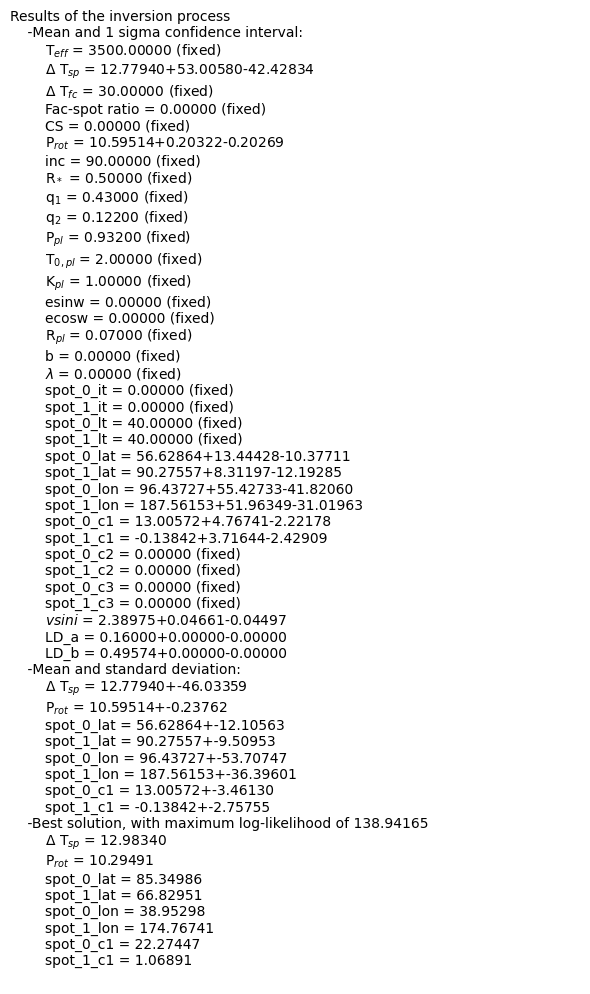

In [24]:
ss=starsim.StarSim(conf_file_path='starsim.conf') #initialize configuration and spot map
ss.load_data(t=t_sampling,y=y_lc,yerr=dy_lc,instrument='DUMMY-lc',observable='lc',filter_name='TJO_R.dat',wvmin=5500,wvmax=9500,offset=1,jitter=0,fix_offset=True,fix_jitter=False)
ss.load_data(t=t_sampling,y=y_rv,yerr=dy_rv,instrument='DUMMY-rv',observable='rv',wvmin=5500,wvmax=9500,offset=0,jitter=0,fix_offset=True,fix_jitter=False)

ss.optimize_MCMC()

In [33]:
ss.plot_MCMCoptimization_chain()
ss.plot_MCMCoptimization_likelihoods()
ss.plot_MCMCoptimization_corner()
ss.plot_MCMCoptimization_results(Nsamples = 50, t=np.linspace(t_sampling[0],t_sampling[-1], 200), fold = False)


 [49/50]

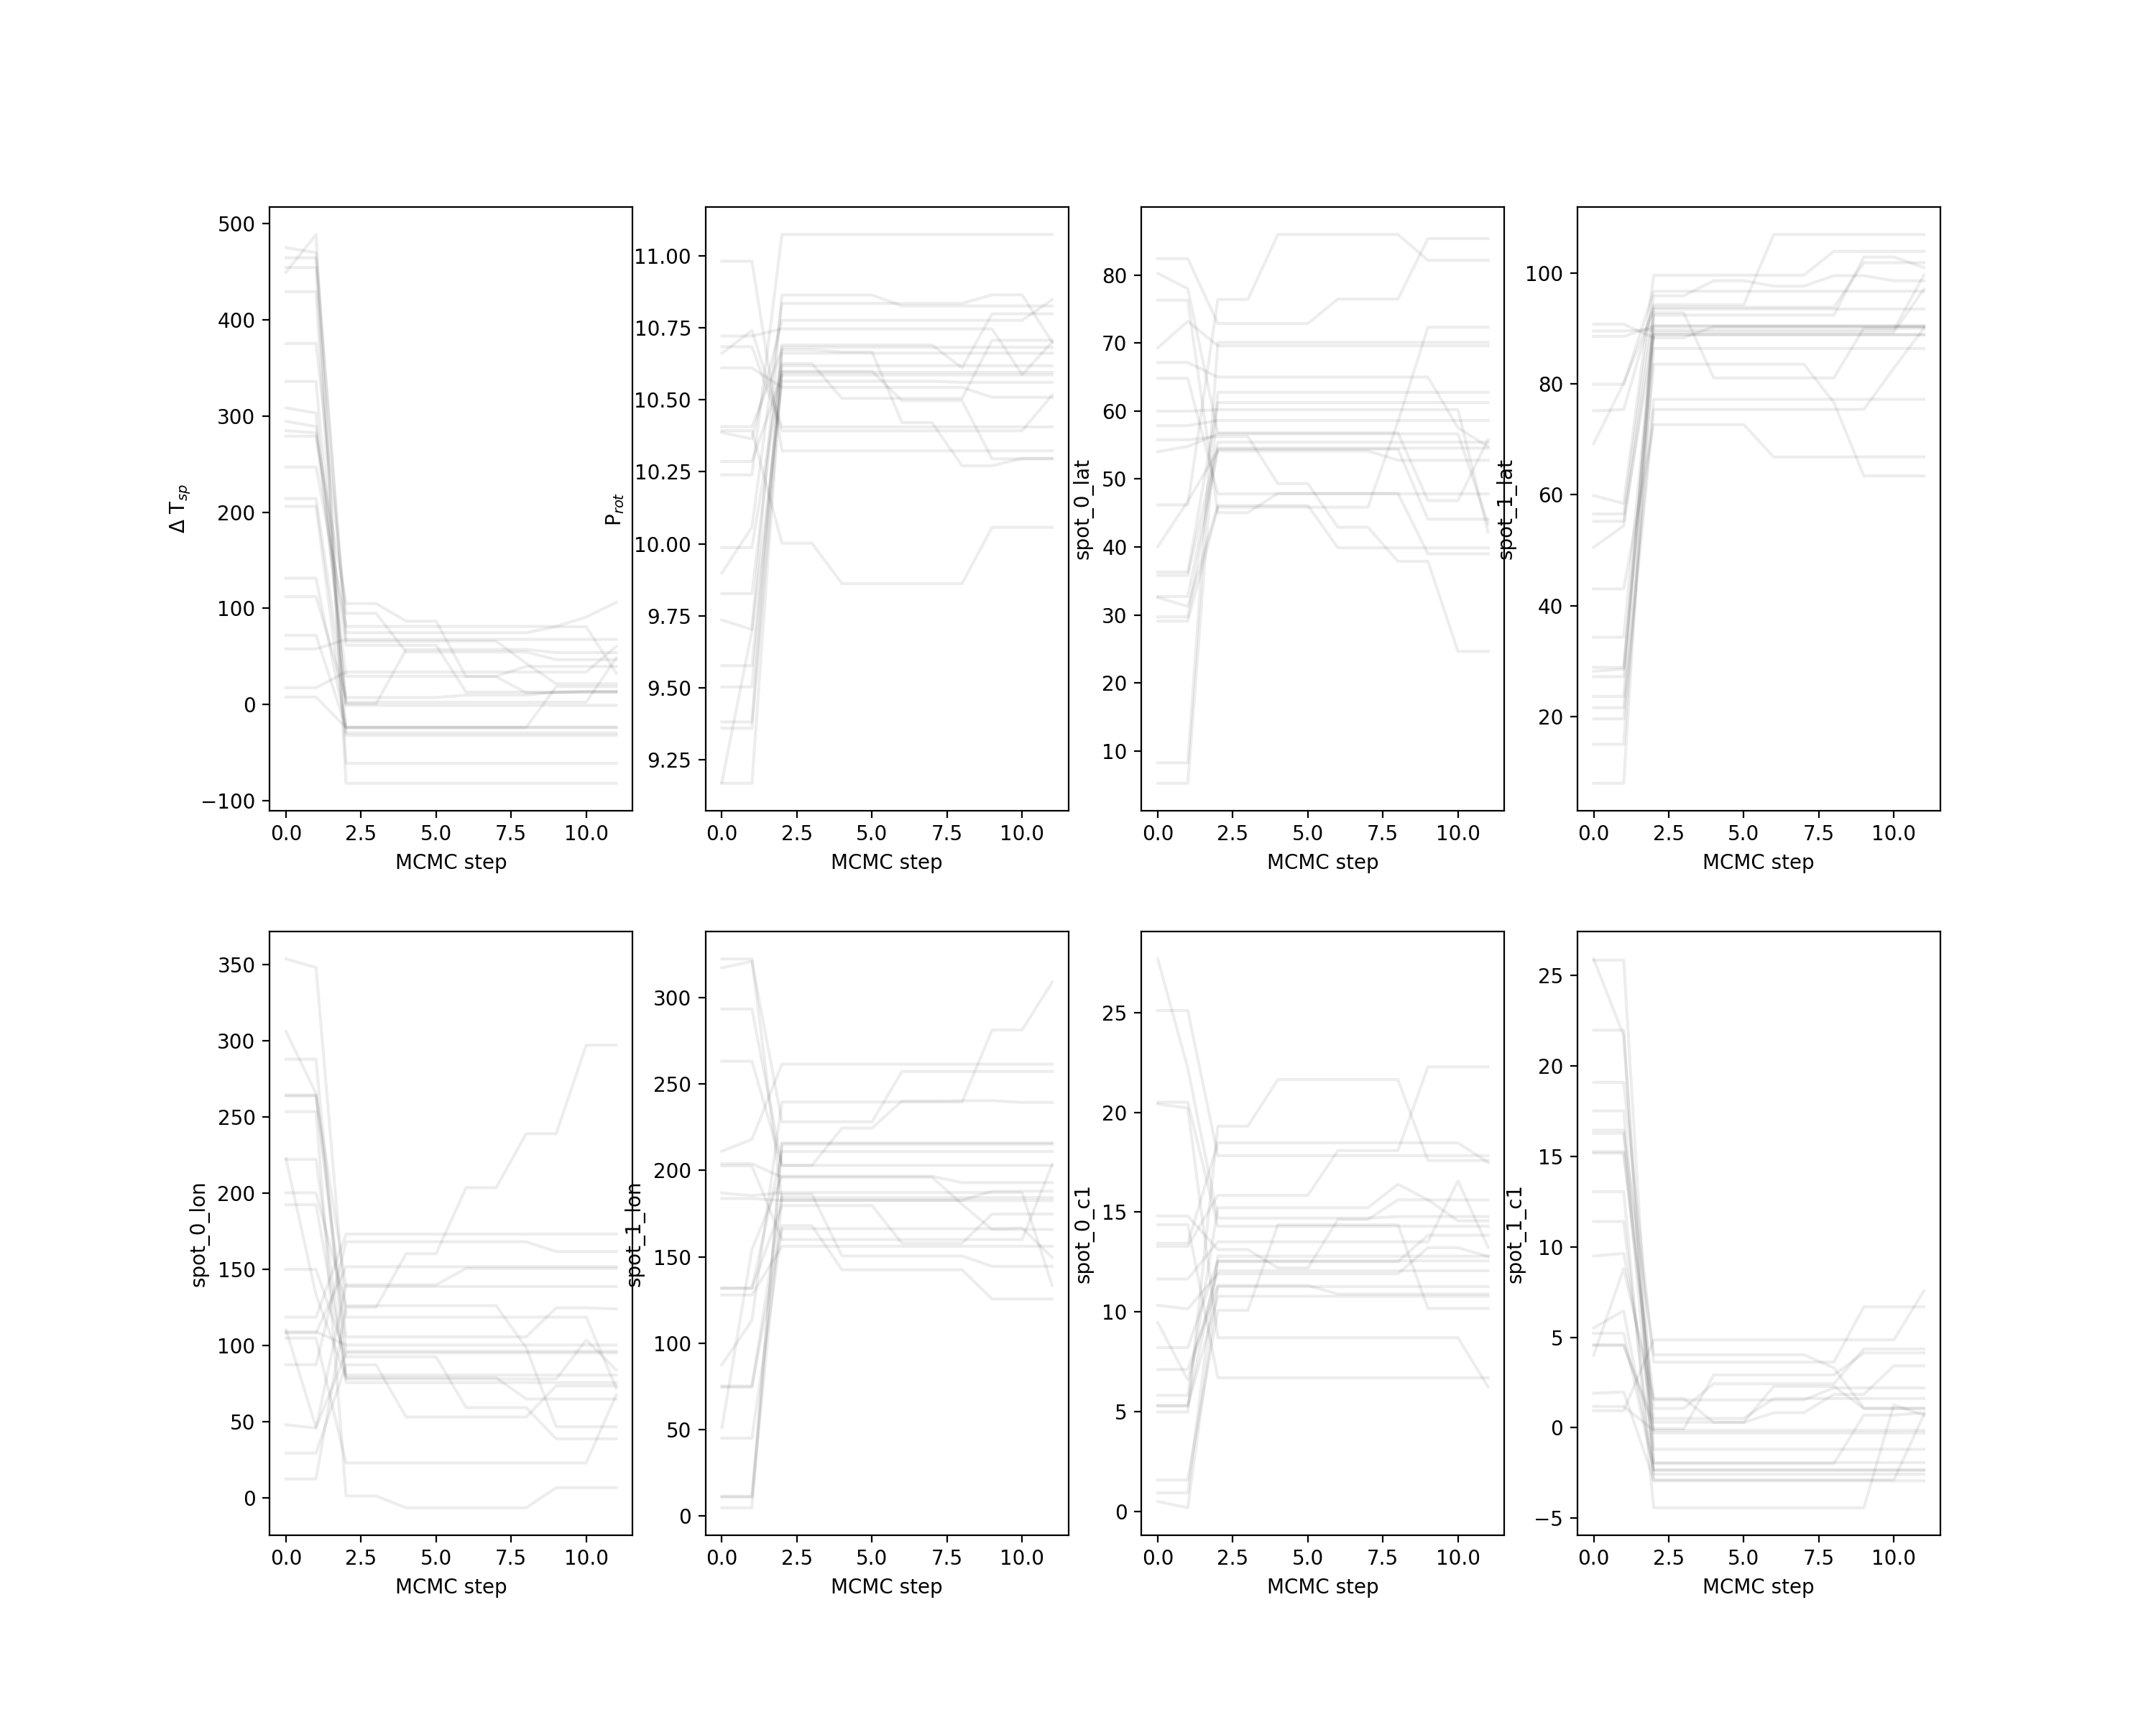

In [27]:
Image(filename='starsim/plots/MCMCoptimization_chains.png',width=800) 

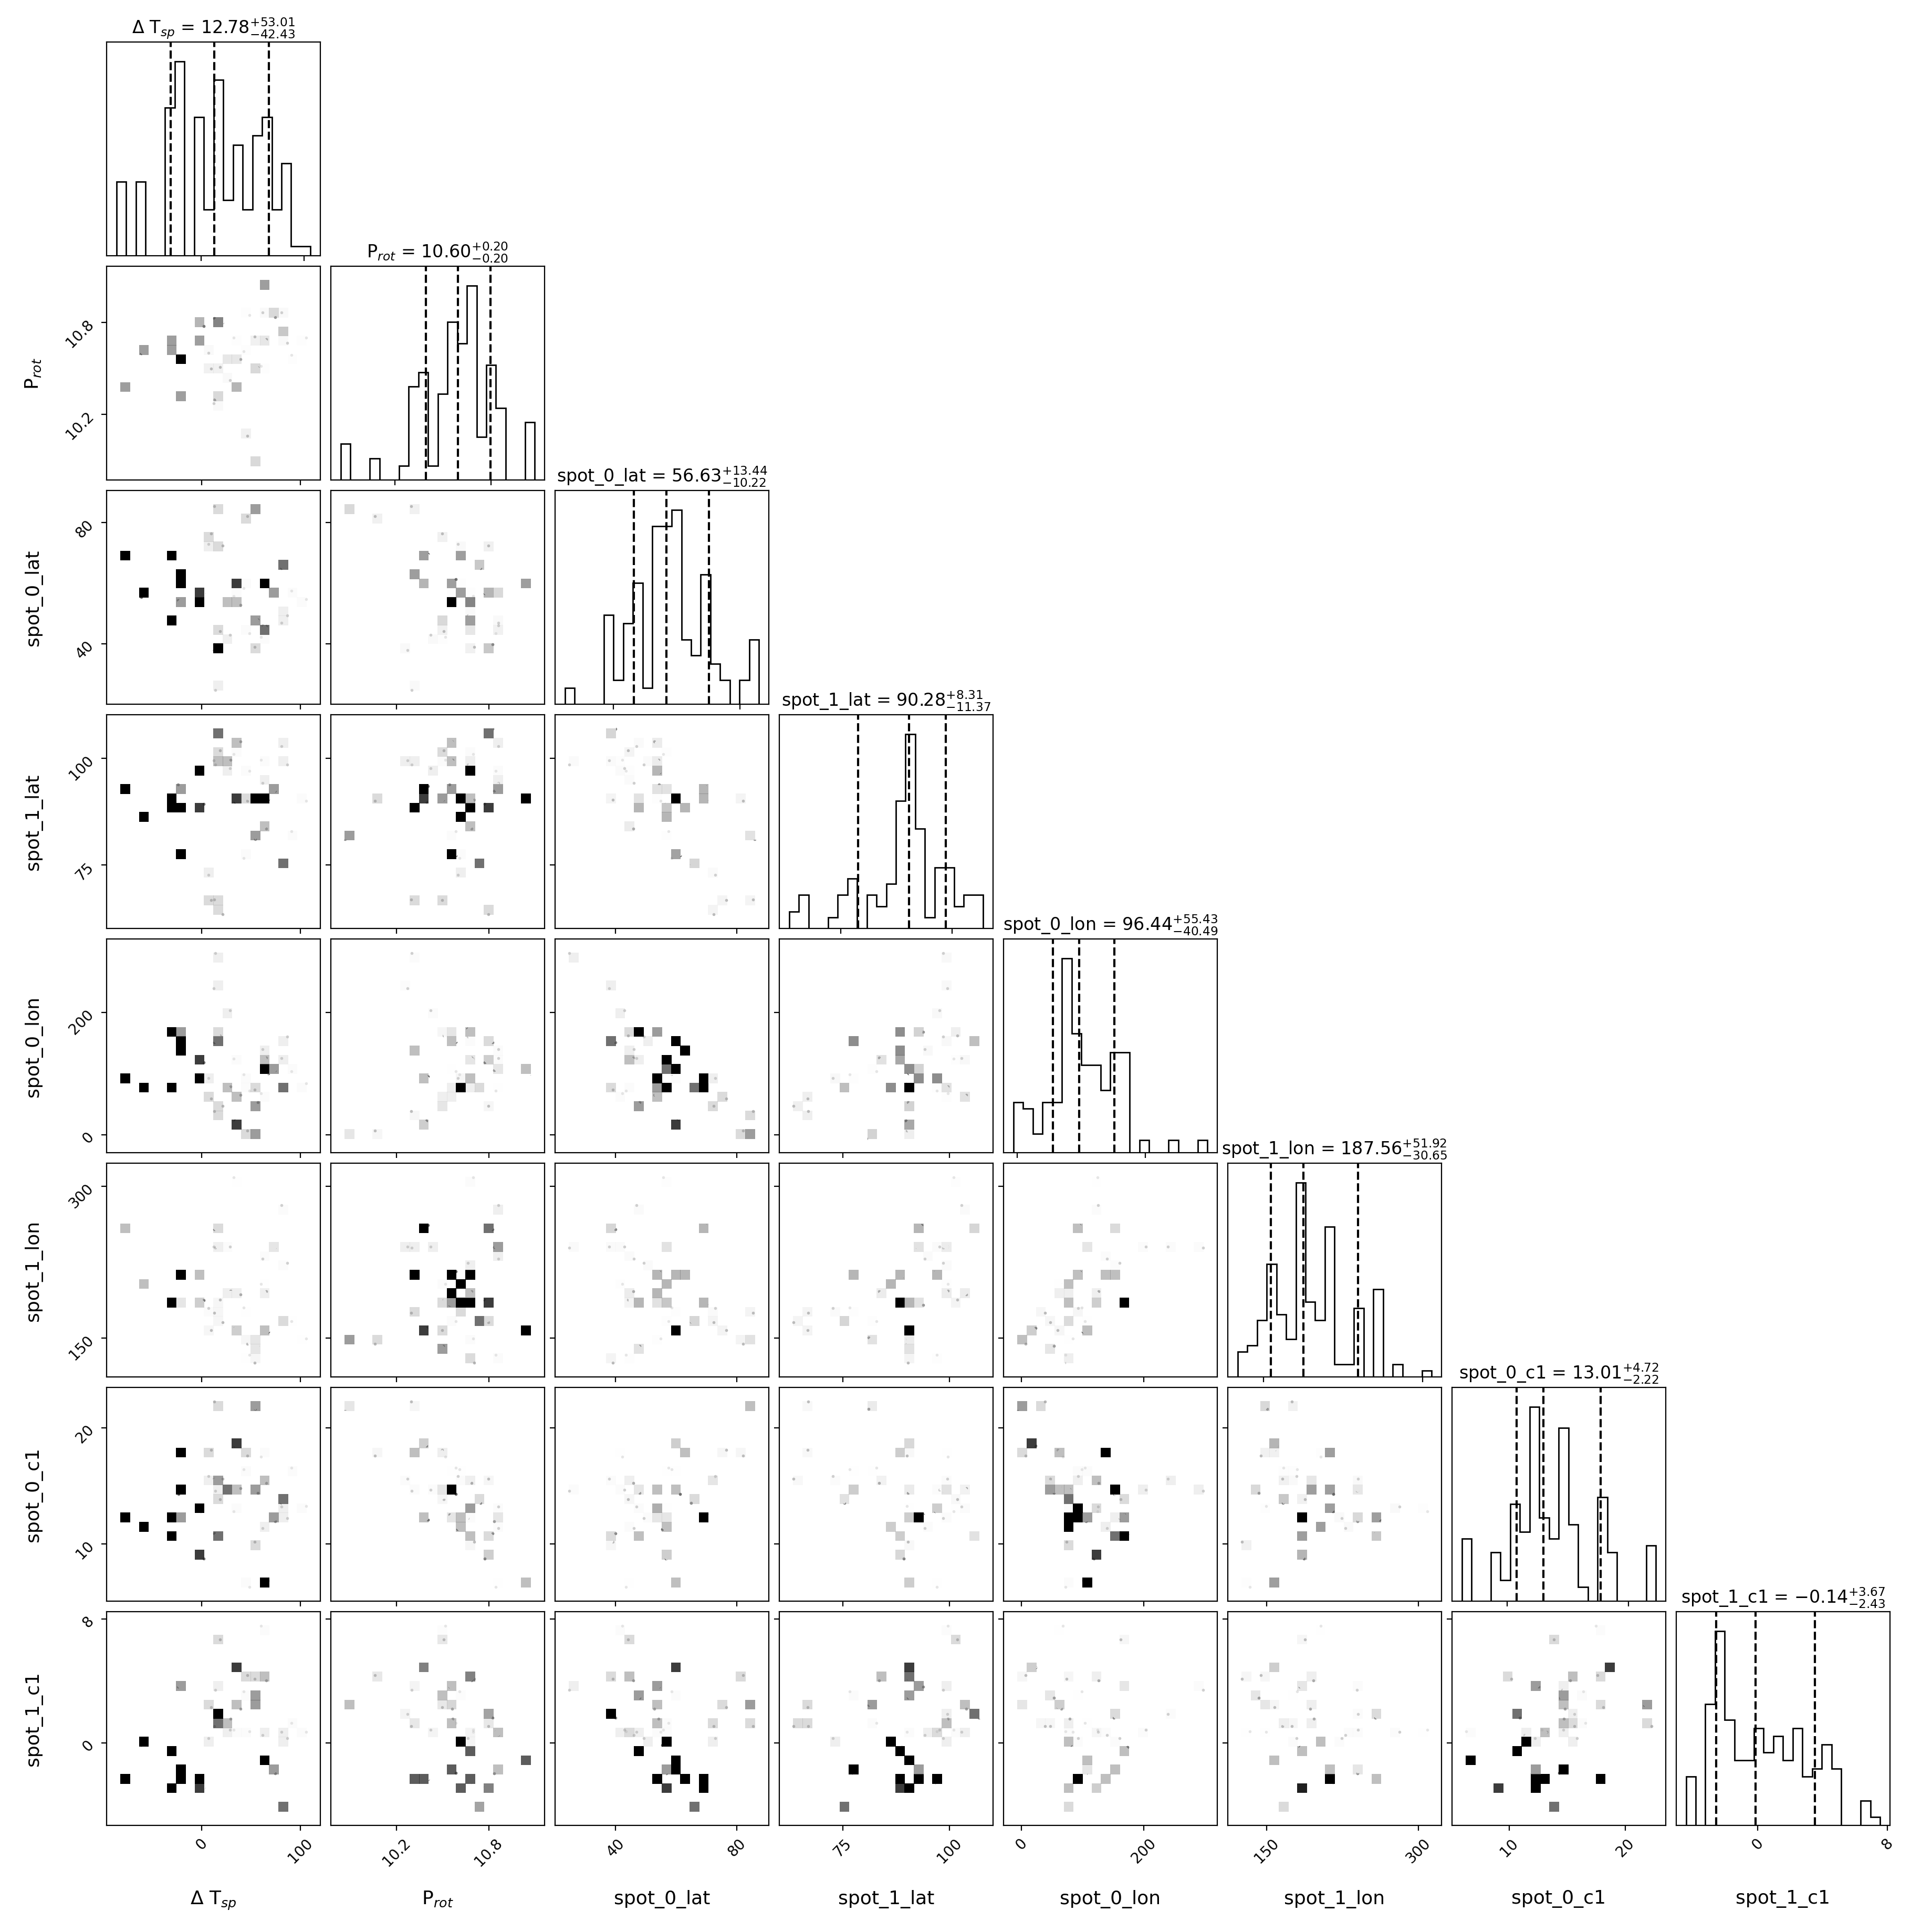

In [28]:
Image(filename='starsim/plots/MCMCoptimization_cornerplot.png',width=500) 

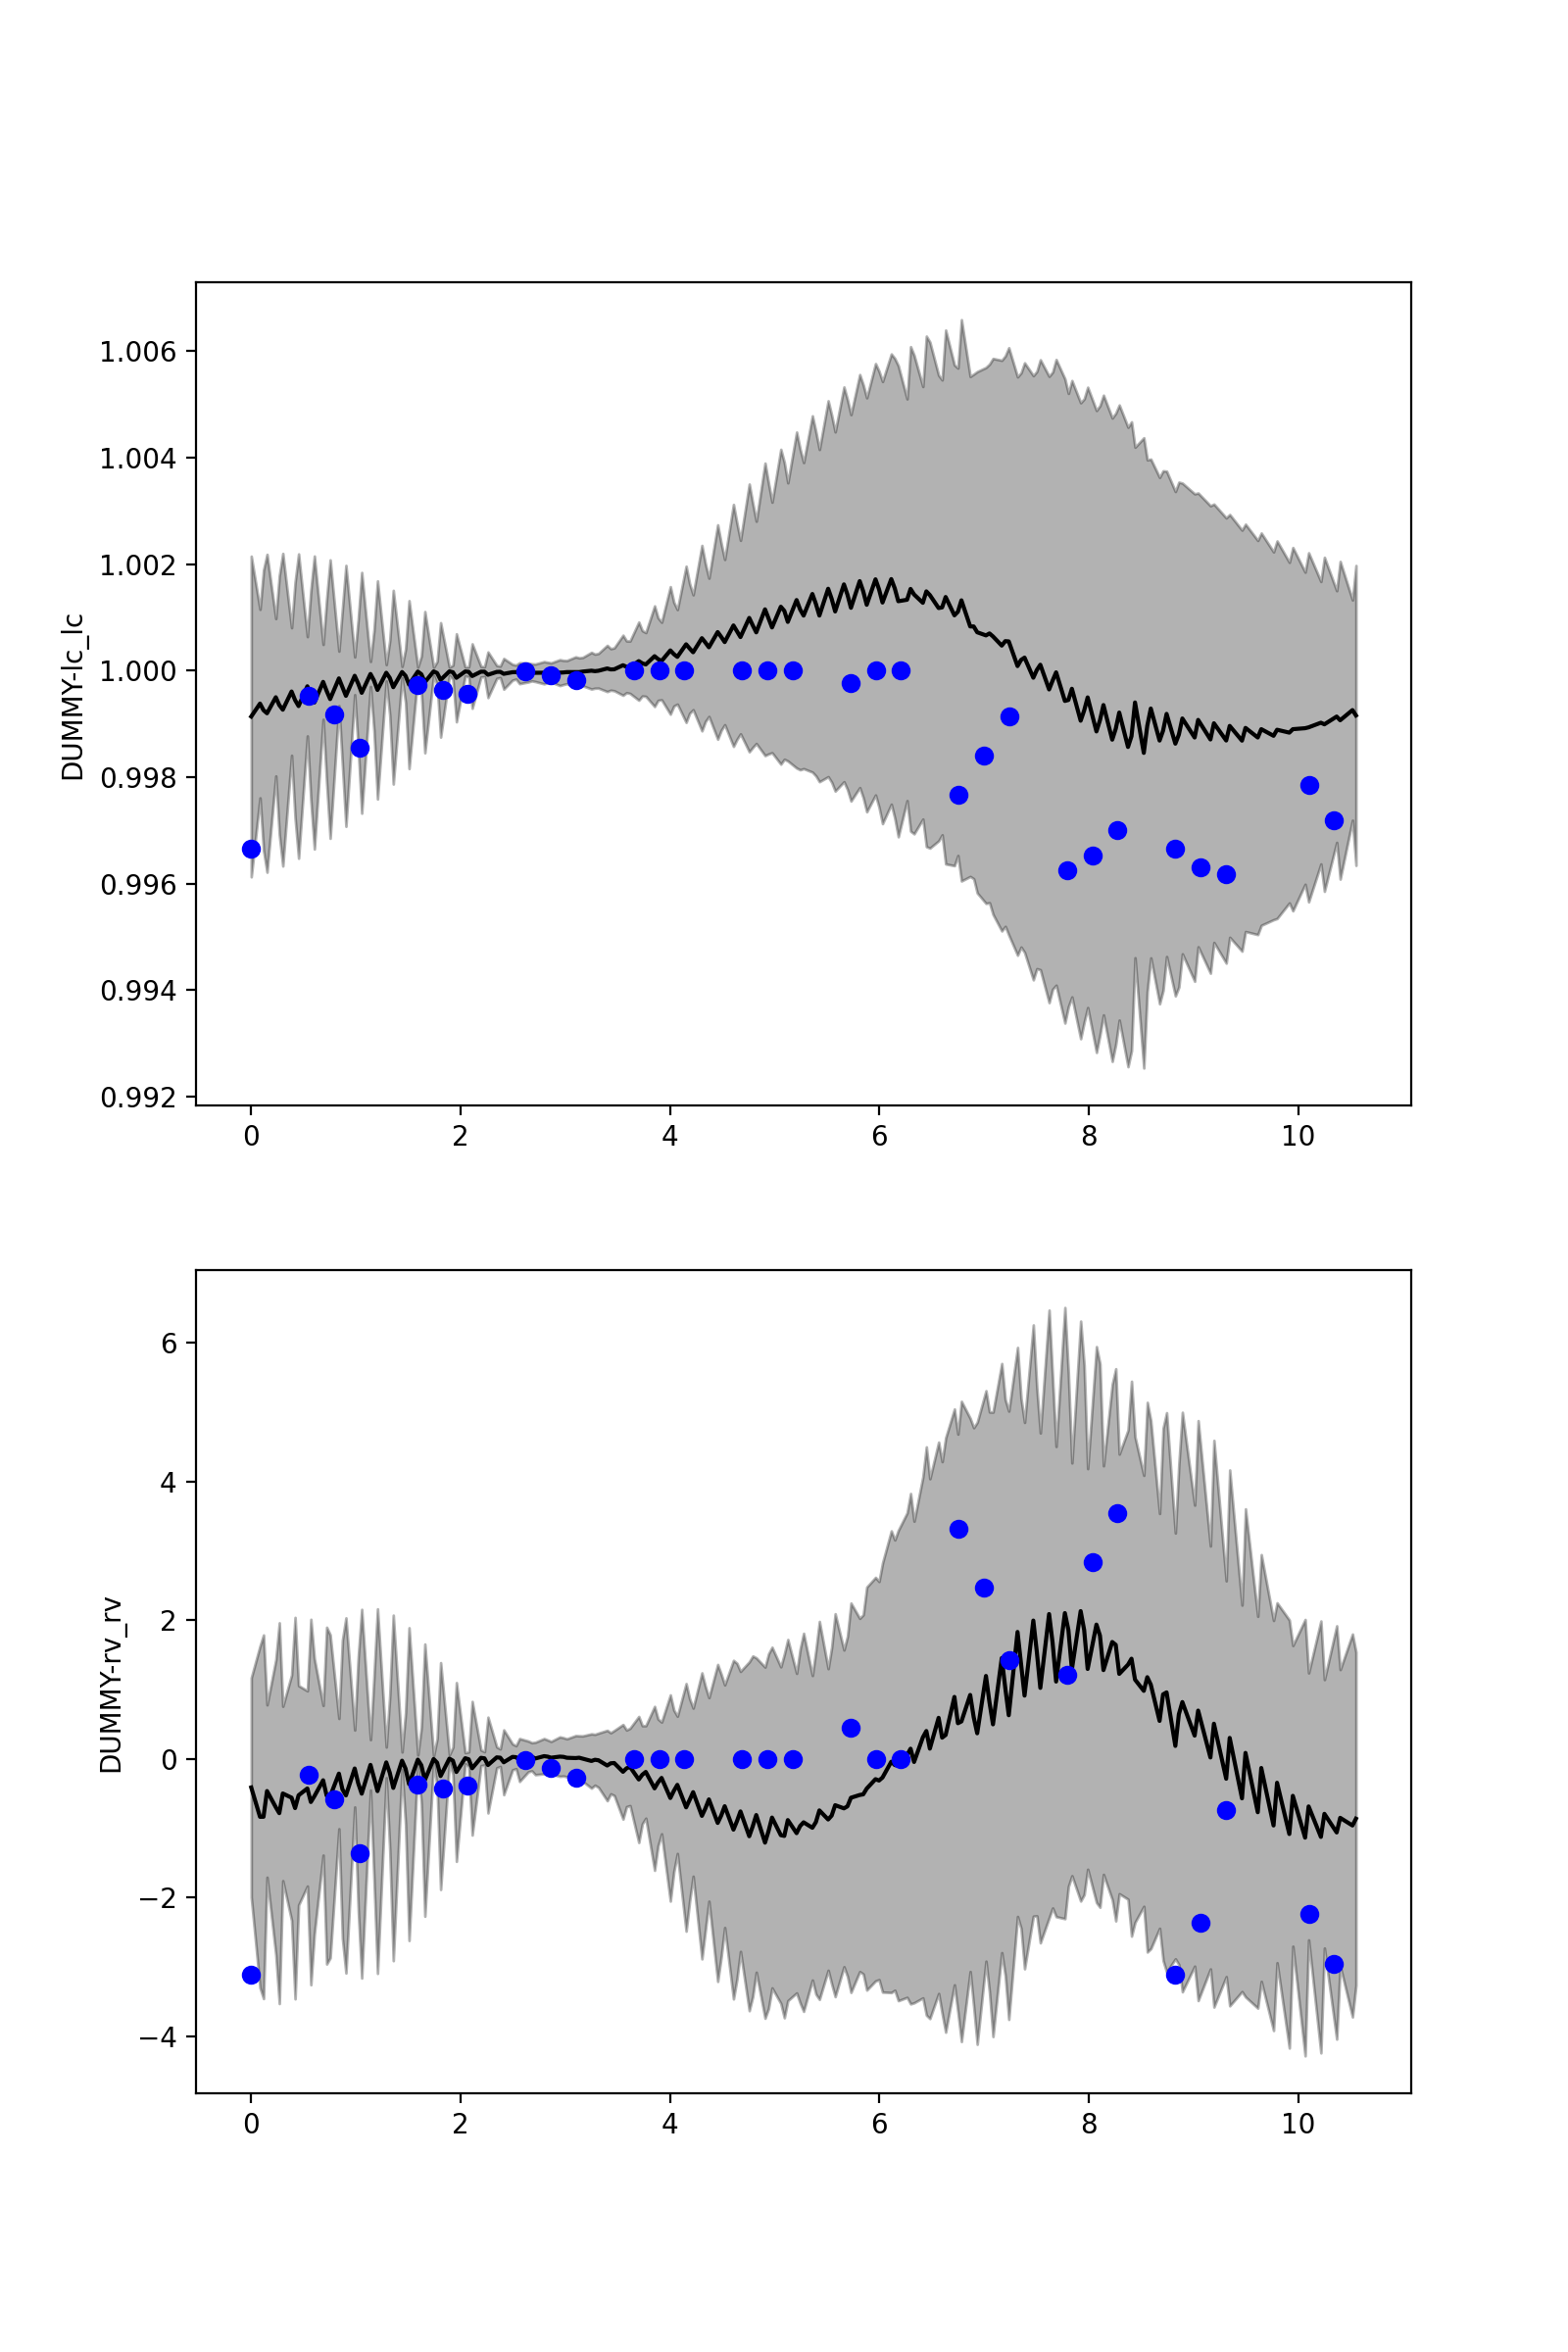

In [30]:
Image(filename='starsim/plots/MCMCoptimization_timeseries_result.png',width=600) 

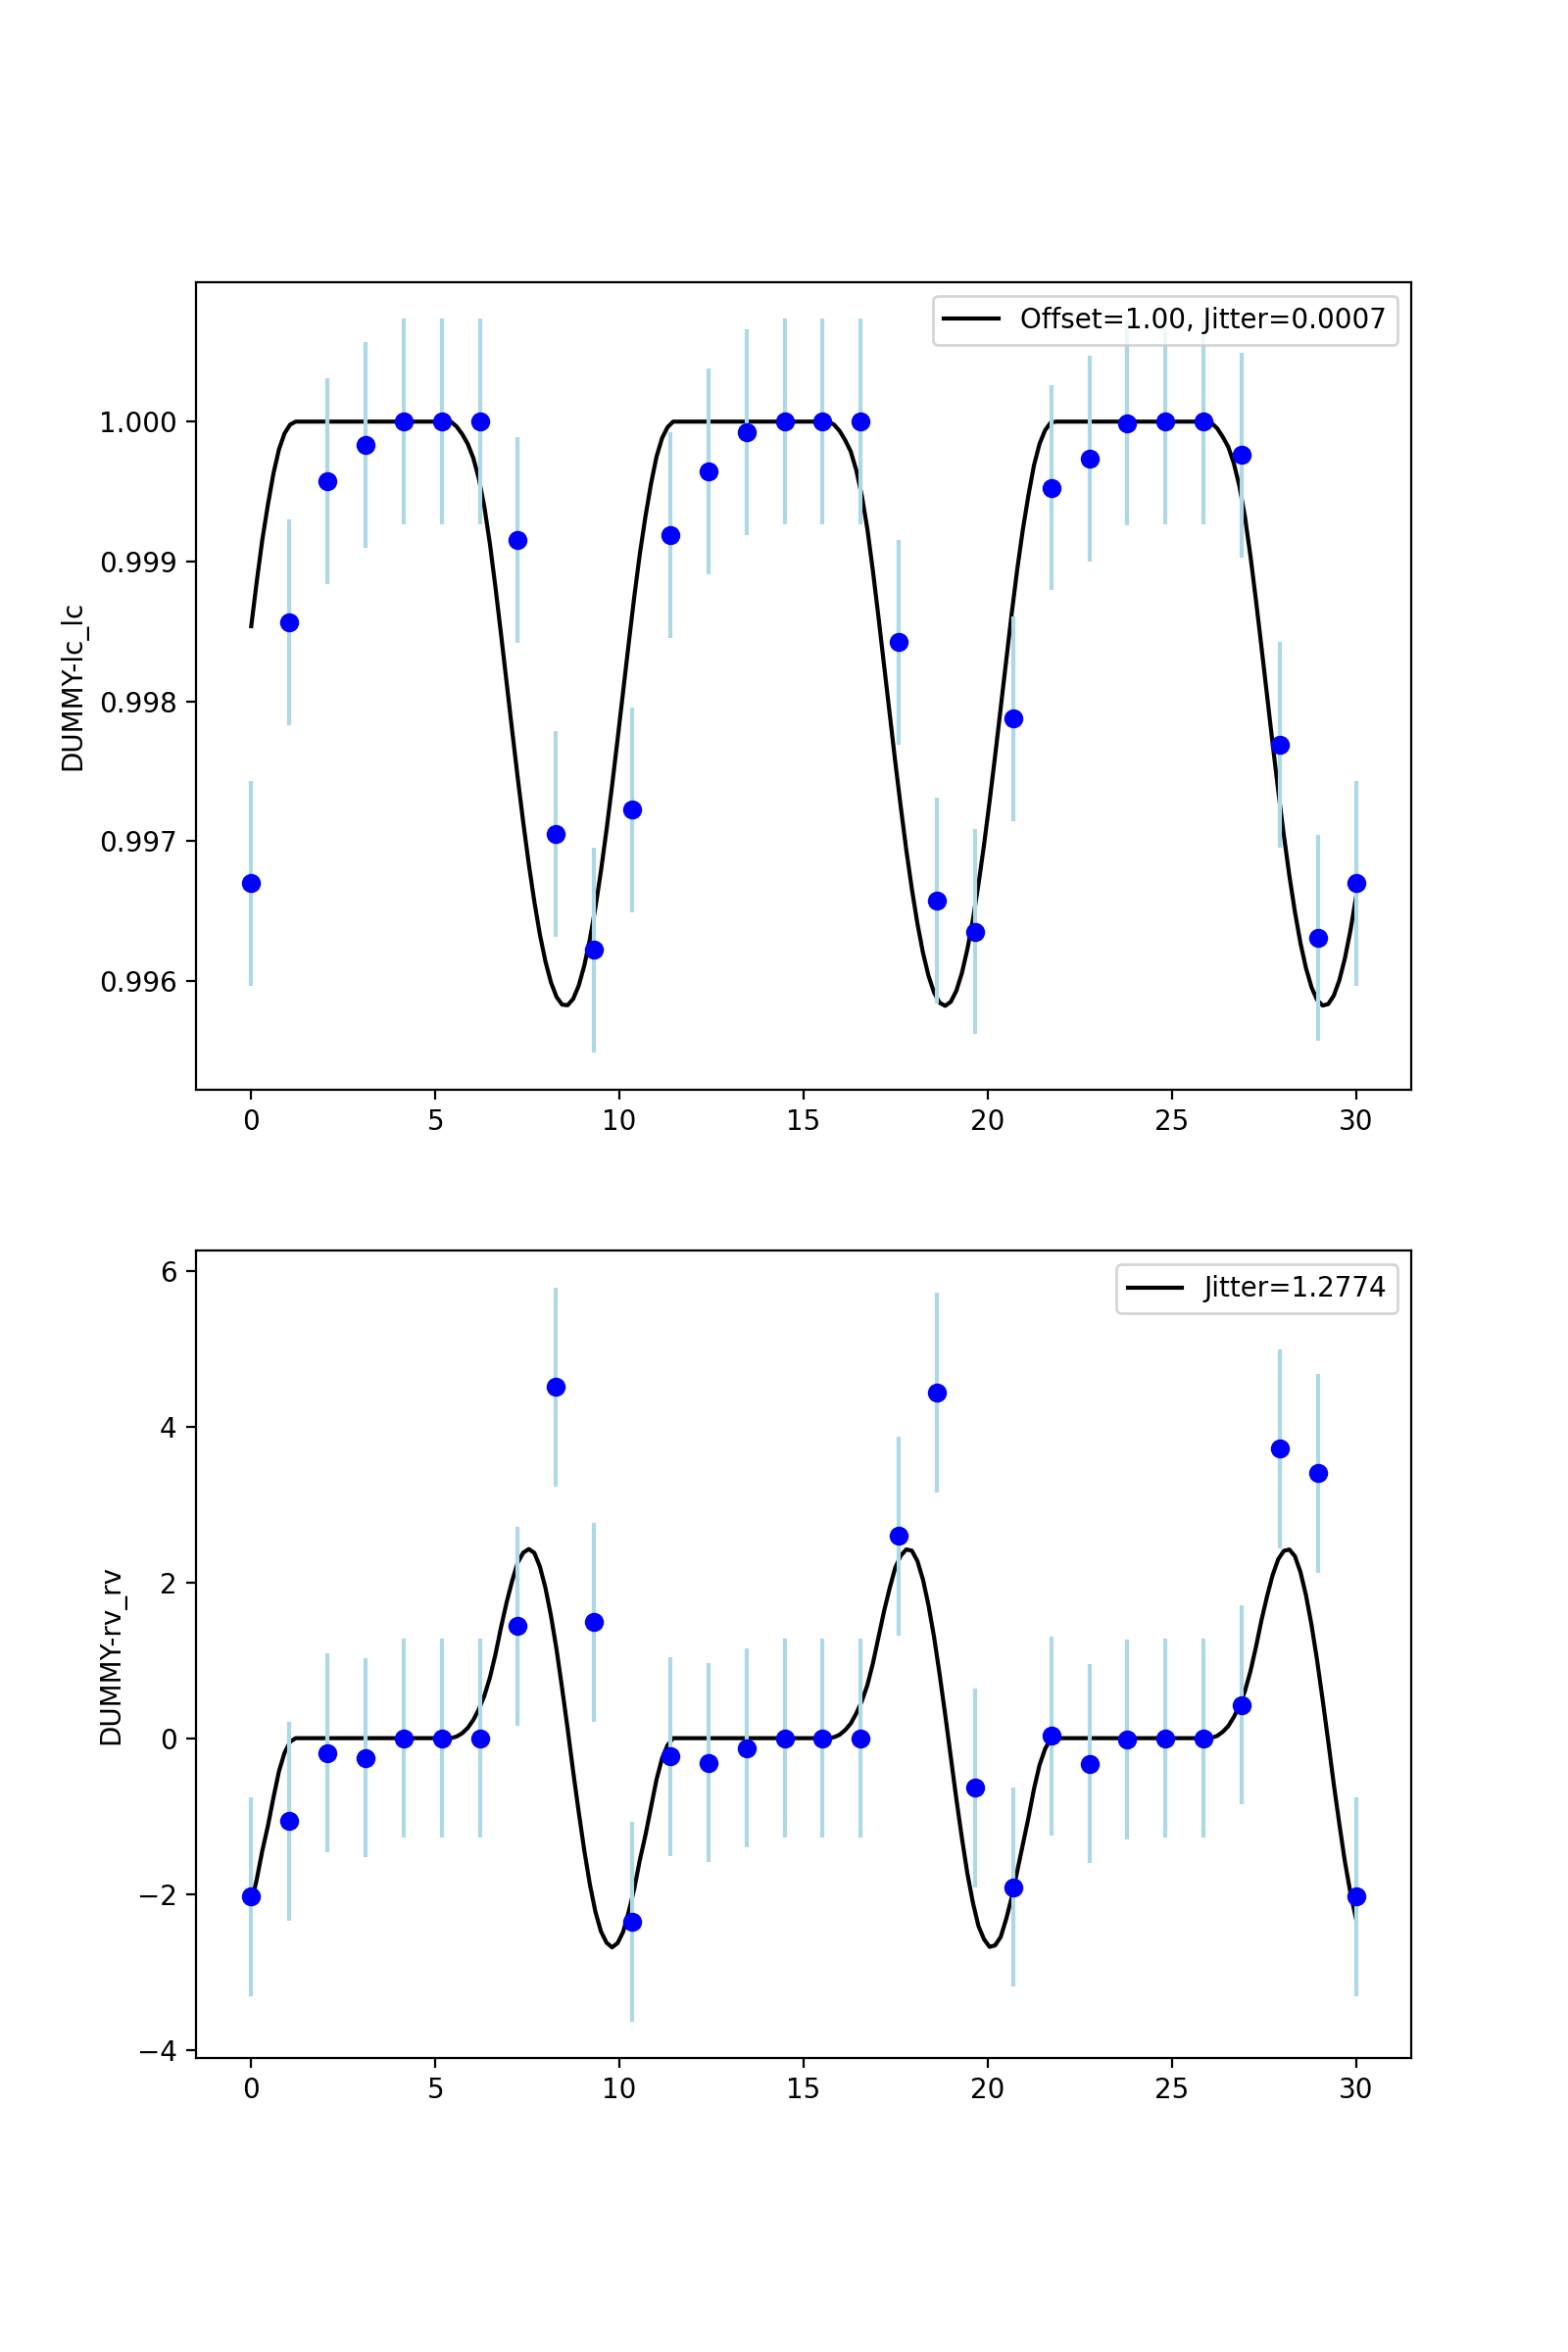

In [29]:

Image(filename='starsim/plots/MCMCoptimization_timeseries_best_result.png',width=300)